## Offshore Wind Energy Potentials in the North Sea Region ##

Before executing: 
Execute supplementary scripts. These will create necessary input data.
<br>
Download IHO-EEZ intersect: https://www.vliz.be/en/imis?dasid=6404&doiid=402 and IHO defintion of seas https://www.vliz.be/en/imis?dasid=5444&doiid=323, GEBCO bathymetry data https://www.bodc.ac.uk/data/published_data_library/catalogue/10.5285/f98b053b-0cbc-6c23-e053-6c86abc0af7b/
Route Density data from: https://emodnet.ec.europa.eu/geonetwork/srv/eng/catalog.search#/metadata/74eef9c6-13fe-4630-b935-f26871c8b661

A possible error might be: 
    **ConnectionError: HTTPSConnectionPool(host='openenergy-platform.org', port=443): Max retries exceeded with url: /api/v0/schema/supply/tables/wind_turbine_library/rows (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002E1A352F7C0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))**
    <br> In this case, just retry.

In [245]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

import numpy as np
import functools
import rasterstats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.reset_option('display.max_rows')
#from IPython.display import display
#with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
#    display(df)
pd.set_option('display.max_colwidth',150)

import matplotlib.ticker as ticker
from shapely.geometry import Polygon
import geopandas


In [246]:
import time
start = time.time()

**Creating a cutout for the time series validation**
<br>
<br> The cutout is delimited by a border drawn between Shetland Islands, Kattegat, Strait of Dover and Shetland Islands.


In [247]:

cutout = atlite.Cutout(path="north-sea-region-jan21_2.nc",
                       module="era5",
                       x=slice(-4.2600, 10.0000),
                       y=slice(51.0000, 60.8479),
                       time=slice("2021-01-15","2021-02-15") # until 25th of Jan: time=slice("2019-03-01","2019-03-31")
                       )


In [248]:
cutout.prepare()

INFO:atlite.data:Cutout already prepared.


<Cutout "north-sea-region-jan21_2">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.00 ⟷ 60.75, dy = 0.25
 time = 2021-01-15 ⟷ 2021-02-15, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [249]:
cutout.data
cutout.wind
cutout.prepared_features


<xarray.Dataset>
Dimensions:           (x: 58, y: 40, time: 768)
Coordinates:
  * x                 (x) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0
  * y                 (y) float64 51.0 51.25 51.5 51.75 ... 60.25 60.5 60.75
  * time              (time) datetime64[ns] 2021-01-15 ... 2021-02-15T23:00:00
    lon               (x) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(40,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(40, 58), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 40, 58), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['runoff', 'temperature', 'wind', 'height', 'influx']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-03-29 18:05:04 GMT by grib_to_netcdf-2.25.1: /op...

<bound method wind of <Cutout "north-sea-region-jan21_2">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.00 ⟷ 60.75, dy = 0.25
 time = 2021-01-15 ⟷ 2021-02-15, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']>

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

**Create a cutout for an entire year for the yield map**


In [250]:

yield_cutout = atlite.Cutout(path="north-sea-region-21-total",
                       module="era5",
                       x=slice(-4.2600, 10.0000),
                       y=slice(51.0000, 60.8479),
                       time=slice("2021-01-01","2021-12-31") # until 25th of Jan: time=slice("2019-03-01","2019-03-31")
                       )


In [251]:
yield_cutout.prepare(features=[ 'wind'])
                               
                               #Z. 600 https://github.com/PyPSA/atlite/blob/625ca8310b4a3686b7b6fb50aa08bfedf7b46f49/atlite/cutout.py

INFO:atlite.data:Storing temporary files in C:\Users\march\AppData\Local\Temp\tmp5k54zapx


<Cutout "north-sea-region-21-total">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.00 ⟷ 60.75, dy = 0.25
 time = 2021-01-01 ⟷ 2021-12-31, dt = H
 module = era5
 prepared_features = ['wind']

**Importing country shapefiiles**

In [252]:

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
#Select the north sea bordering states
BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) 

cells = cutout.grid
projection = ccrs.Orthographic( -5,30)
country_bound = gpd.GeoSeries(cells.unary_union)

In [253]:
#BorderingStates_init.crs

In [254]:
cells.bounds

minx    miny    maxx    maxy
0    -4.375  50.875  -4.125  51.125
1    -4.125  50.875  -3.875  51.125
2    -3.875  50.875  -3.625  51.125
3    -3.625  50.875  -3.375  51.125
4    -3.375  50.875  -3.125  51.125
...     ...     ...     ...     ...
2315  8.875  60.625   9.125  60.875
2316  9.125  60.625   9.375  60.875
2317  9.375  60.625   9.625  60.875
2318  9.625  60.625   9.875  60.875
2319  9.875  60.625  10.125  60.875

[2320 rows x 4 columns]

**Plotting the cutout with abstract land borders**

(-4.375, 50.875, 10.125, 60.875)

<GeoAxesSubplot:>

<GeoAxesSubplot:>

<GeoAxesSubplot:>

'Region of analysis'

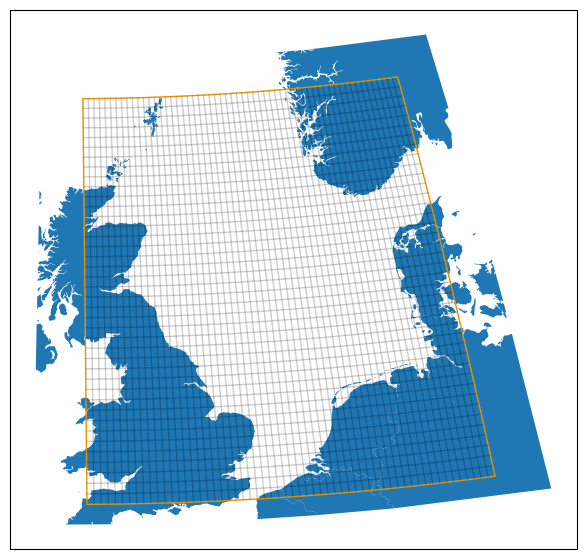

In [255]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(1,1,1, projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())

# we need to clip the predefined country border because they extend to Southern France and Svalbard

# a visual cutout of the north sea region is slightly larger than the actual cutout
display(cells.unary_union.bounds)
lat_point_list = [50.4,61.8479, 61.8479, 50.4,50.4]
lon_point_list = [-6.26, -6.26 , 12 ,12, -6.26 ]
polygon2 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf2 = gpd.GeoDataFrame([1], geometry=[polygon2], crs=cutout.grid.crs)
BorderingStates_init= BorderingStates_init.clip(poly_gdf2)

BorderingStates_init.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())

#ax.outline_patch.set_edgecolor('black') #deprecated?
ax.set_frame_on(True)
'Region of analysis'

#set_xlim und set_ylim funktionieren nicht 
#ax. set_extent([-4.375, 51.375, 10.125, 60.875],crs=geodetic()) auch nicht

**Reading invthe windfarms from EMODNet with a map from OpenStreetMap**

In [256]:
import contextily as cx

#data of European Offshore wind farms is imported

windfarm_map= gpd.read_file(r"..\data\EMODnet_HA_WindFarms_20221219\EMODnet_HA_WindFarms_pg_20221219.shp")

# Firstly, we reduce the set to north sea bordering countries
windfarm_map=windfarm_map[windfarm_map["COUNTRY"].isin(['France','United Kingdom','Denmark','Belgium','Norway','Germany','Netherlands'])]



The data contains necessarily wind farms beyond the North Sea due to country as a selection criterion.

**Select subset of windfarms that are located in the cutout**

In [257]:
windfarm_map.columns
windfarm_map.head()

#take the polygon from the initial cutout and use it to reduce the initial country-based dataset
# a selection based on visual adherence to the region is not viable since the objectids have no geograpic correlation
#and the dataset containts more than 200 windfarms
lat_point_list = [51.0,60.8479, 60.8479,51.0,51.0]
lon_point_list = [-4.26, -4.26 , 10 ,10, -4.26 ]
polygon3 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf3 = gpd.GeoDataFrame([1], geometry=[polygon3], crs=windfarm_map.crs)

windfarm_map_reduced = gpd.overlay(windfarm_map,poly_gdf3, how='intersection')
#that function also eliminates polygons outside of the scope of polygon 3 from our GeoPandas Dataframe
# but will also cut off border polygons 


Index(['OBJECTID', 'COUNTRY', 'NAME', 'N_TURBINES', 'POWER_MW', 'STATUS',
       'YEAR', 'COAST_DIST', 'AREA_SQKM', 'NOTES', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

OBJECTID         COUNTRY                     NAME  N_TURBINES  POWER_MW  \
3         4  United Kingdom      Galson (Lewis 10MW)          10      10.0   
4         5  United Kingdom          Islay Demo Zone          10      10.0   
5         6  United Kingdom  North West Lewis (30MW)          30      30.0   
6         7  United Kingdom              Brough Ness          66      99.0   
7         8  United Kingdom        Brims Tidal Array         200     200.0   

     STATUS  YEAR   COAST_DIST  AREA_SQKM NOTES  Shape_Leng  Shape_Area  \
3   Planned     0    45.484159   4.756372  None    0.124678    0.000731   
4  Approved     0  1122.942248  27.621564  None    0.291914    0.003946   
5   Planned     0     0.000000  50.982576  None    1.282082    0.007829   
6   Planned     0   262.104684   2.990592  None    0.139683    0.000463   
7   Planned     0   410.971295  11.033219  None    0.317197    0.001711   

                                                                                                                                                geometry  
3  POLYGON ((-6.48391 58.43840, -6.45466 58.41987, -6.45467 58.41987, -6.45482 58.41983, -6.45502 58.41978, -6.45501 58.41985, -6.45499 58.41992, -6....  
4                           POLYGON ((-6.52572 55.65146, -6.55948 55.64928, -6.60886 55.73771, -6.53729 55.73251, -6.54283 55.68982, -6.52572 55.65146))  
5  MULTIPOLYGON (((-6.58016 58.36416, -6.58043 58.36409, -6.58068 58.36400, -6.58083 58.36393, -6.58104 58.36391, -6.58120 58.36395, -6.58134 58.3639...  
6  POLYGON ((-2.92591 58.72239, -2.94334 58.71778, -2.96177 58.72249, -2.96200 58.72680, -2.94560 58.72796, -2.93040 58.72956, -2.92926 58.72983, -2....  
7  POLYGON ((-3.18297 58.75791, -3.17420 58.74915, -3.22048 58.75411, -3.29183 58.75331, -3.30968 58.76548, -3.31163 58.76649, -3.31269 58.76730, -3....

INFO:shapely.geos:Ring Self-intersection at or near point -2.719882692831959 57.690370521682269


In [258]:
windfarm_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Discard windfarms from the data set, that are not located in the North Sea**
<br> **i.e. off the coast of Cardif** : Bristol Channel <br> **in the Irish Sea** Liverpool Bay and Morecambe Bay

In [259]:

windfarm_map_reduced.shape

#define areas that are to be discarded
#again: selection is done by polygons instead of hand-selecting
xmin,ymin,xmax,ymax= cells.total_bounds

#Irish Sea
lat_point_list = [ymin,55.0, 55.0,ymin,ymin]
lon_point_list = [xmin, xmin , -2 ,-2, xmin ]
orig_polygon4 = Polygon(zip(lon_point_list, lat_point_list))
polygon4 = Polygon([orig_polygon4.boundary.interpolate(i, normalized=True) for i in np.linspace(0, 1, 10000)])
poly_gdf_excl_west = gpd.GeoDataFrame([1], geometry=[polygon4], crs=windfarm_map_reduced.crs)


#Baltic Sea
lat_point_list = [ymin,56.5, 56.5,ymin,ymin]
lon_point_list = [9.5, 9.5 , xmax ,xmax, 9.5 ]
orig_polygon5 = Polygon(zip(lon_point_list, lat_point_list))
polygon5 = Polygon([orig_polygon5.boundary.interpolate(i, normalized=True) for i in np.linspace(0, 1, 10000)])
poly_gdf_excl_east = gpd.GeoDataFrame([1], geometry=[polygon5], crs=windfarm_map_reduced.crs)

#within-function demands a gp-series, the argument needs to be a shapely-object
bool1= windfarm_map_reduced.within(polygon4) #ergibt eine Boolean-Tabelle
bool2= windfarm_map_reduced.within(polygon5)
#use boolean logic to create a mask that excludes both areas
bool3= bool1 + bool2

#windfarm_map_reduced
#use boolean filtering
windfarm_new= windfarm_map_reduced[~bool3.values]




(265, 14)

In [260]:

windfarm_new.reset_index(drop=True, inplace=True)
windfarm_new.shape
pd.set_option('display.max_rows', 1000)

#display the dataset
#windfarm_new


(243, 14)

**Which turbine types are available in atlite?**

In [261]:
turbines_atlite= [t for t in atlite.windturbines] #list comprehension                    
turbines_atlite =pd.Series(turbines_atlite)
turbines_atlite
#for t in atlite.windturbines: print(f'* {t}') #displaying all built-in turbines

#if turbines have been imported, their name will show up here

0                                 Bonus_B1000_1000kW
1                                Enercon_E101_3000kW
2                                Enercon_E126_7500kW
3                                 Enercon_E82_3000kW
4     NREL_ReferenceTurbine_2016CACost_10MW_offshore
5      NREL_ReferenceTurbine_2016CACost_6MW_offshore
6      NREL_ReferenceTurbine_2016CACost_8MW_offshore
7     NREL_ReferenceTurbine_2019ORCost_12MW_offshore
8     NREL_ReferenceTurbine_2019ORCost_15MW_offshore
9        NREL_ReferenceTurbine_2020ATB_12MW_offshore
10       NREL_ReferenceTurbine_2020ATB_15MW_offshore
11       NREL_ReferenceTurbine_2020ATB_18MW_offshore
12                 NREL_ReferenceTurbine_2020ATB_4MW
13               NREL_ReferenceTurbine_2020ATB_5.5MW
14                 NREL_ReferenceTurbine_2020ATB_7MW
15                NREL_ReferenceTurbine_5MW_offshore
16                            Siemens_SWT_107_3600kW
17                                Siemens_SWT_2300kW
18                                 Suzlon_S82_

New Turbine Power curves can be found under: https://openenergy-platform.org/dataedit/view/supply/wind_turbine_library <br>
An atlite command imports these for further processing.
<br> Not every turbine in the turbine library has a power curve.

In [262]:
import requests
import numpy as np
OEDB_URL = "https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows"

# Cache turbine request locally

# Get the turbine list
result = requests.get(OEDB_URL)
# Convert JSON to dataframe for easier filtering
# Only consider turbines with power curves available
df = pd.DataFrame.from_dict(result.json())
oedb_turbines = df[df.has_power_curve]
oedb_turbines.shape
oedb_turbines_mask = df[['id']].isin(oedb_turbines)
oedb_turbines_mask.rename({'id':'has_power_curve'},axis=1,inplace=True)
oedb_turbines_mask.value_counts()


(68, 25)

has_power_curve
False              73
True               68
dtype: int64

In [263]:
#an example how the ATLITE method collects new windturbines from open energy platform
#but will only request turbines that have a power curve
from atlite.resource import get_oedb_windturbineconfig

#from the API
#atlite.resource.get_windturbineconfig("Siemens_SWT_2300kW") #preinstalled 
#this method can be combined with oedb /  
#atlite.resource.get_windturbineconfig("oedb:V112-3.0 MW") #requested from oedb: one needs the "name" attribute from the table

#get_oedb_windturbineconfig(manufacturer="Nordex")
#an error message for "Nordex" is to be expected since there are multiple entries with

**Reference data from the ENTSOE-API**
<br> ENTSO-E stores generation data on its Transparency Platform.
<br> Requested data is stored in ../data.

In [264]:
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#these data were obtained via the ENTSOE-API and saved in the data-folder
farms_be= pd.read_csv("..\data\BE_4_outfile.csv")
farms_dk = pd.read_csv("..\data\DK_CA_4_outfile.csv")
farms_gb= pd.read_csv("..\data\GB_4_outfile.csv")
#this list can be found on the web
EIC_list = pd.read_excel(r"..\data\GB Electric EIC Library (External) upda.xlsx", sheet_name='ESO W Type Codes - BMUs')

farms_be = farms_be.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 
farms_gb = farms_gb.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 
farms_dk = farms_dk.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 

#remove the first two columns, because they contain descriptors
###use timestamps as Index

farms_dk.drop(labels=[0,1], axis=0,inplace=True)
farms_dk['TimeIndex'] = pd.to_datetime(farms_dk['TimeIndex'],utc=True) #resample only works on a DateTimeIndex
farms_dk = farms_dk.set_index('TimeIndex')
farms_dk = farms_dk.astype(float) #does not change the dtype of the index '#this assignment is necessary, since all values were read in as Strings

farms_be.drop(labels=[0,1], axis=0,inplace=True)
farms_be.set_index('TimeIndex',inplace=True) #other way around works too
farms_be.index = pd.to_datetime(farms_be.index,utc=True)
#type(farms_be.index)
farms_be = farms_be.astype(float) 


#British wind farms need to be translated via the EIC
#list  available at: https://www.nationalgrideso.com/document/167131/download
#EIC_list.head()
abbrev_list= farms_gb.columns.tolist()
translation_list = []
    
translation_dict = {abbrev : EIC_list[EIC_list['Display Name']==abbrev]['EIC Name - Asset Name'].to_string(index=False) for abbrev in abbrev_list}
#translation_list is a dictionary of abbreviation an actual name
translation_dict

#pd.reset_option('display.max_rows')

farms_gb.drop(labels=[0,1], axis=0,inplace=True)
farms_gb['TimeIndex'] = pd.to_datetime(farms_gb['TimeIndex'],utc=True) #resample only works on a DateTimeIndex
farms_gb = farms_gb.set_index('TimeIndex')
farms_gb.index

#only british data are half-hourly
farms_gb = farms_gb.astype(float) 
farms_gb=farms_gb.resample('1H').mean()

#the translation list includes offshore windfarms in the Irish sea

{'TimeIndex': 'Series([], )',
 'ABRBO-1': 'Aberdeen Offshore Wind Farm',
 'BEATO-1': 'Beatrice Offshore Wind Farm ',
 'BEATO-2': 'Beatrice Offshore Wind Farm ',
 'BEATO-3': 'Beatrice Offshore Wind Farm ',
 'BEATO-4': 'Beatrice Offshore Wind Farm ',
 'BOWLW-1': 'Barrow Offshore Wind Farm BOWLW-1',
 'BRBEO-1': 'Burbo Extension BRBEO-1',
 'BURBW-1': 'Burbo Wind Farm BURBW-1',
 'DDGNO-1': 'Dudgeon Offshore Wind Farm DDGNO-1',
 'DDGNO-2': 'Dudgeon Offshore Wind Farm DDGNO-2',
 'DDGNO-3': 'Dudgeon Offshore Wind Farm DDGNO-3',
 'DDGNO-4': 'Dudgeon Offshore Wind Farm DDGNO-4',
 'EAAO-1': 'Series([], )',
 'EAAO-2': 'East Anglia One',
 'GAOFO-1': 'Galloper Offshore Wind Farm GAOFO-1',
 'GAOFO-2': 'Galloper Offshore Wind Farm GAOFO-2',
 'GAOFO-3': 'Galloper Offshore Wind Farm GAOFO-3',
 'GAOFO-4': 'Galloper Offshore Wind Farm GAOFO-4',
 'GNFSW-1': 'Gunfleet Sands GNFSW-1',
 'GNFSW-2': 'Gunfleet Sands GNFSW-2',
 'GRGBW-1': 'Greater Gabbard GRGBW-1',
 'GRGBW-2': 'Greater Gabbard GRGBW-2',
 'GRGBW-3

DatetimeIndex(['2021-01-15 00:00:00+00:00', '2021-01-15 00:30:00+00:00',
               '2021-01-15 01:00:00+00:00', '2021-01-15 01:30:00+00:00',
               '2021-01-15 02:00:00+00:00', '2021-01-15 02:30:00+00:00',
               '2021-01-15 03:00:00+00:00', '2021-01-15 03:30:00+00:00',
               '2021-01-15 04:00:00+00:00', '2021-01-15 04:30:00+00:00',
               ...
               '2021-02-15 19:00:00+00:00', '2021-02-15 19:30:00+00:00',
               '2021-02-15 20:00:00+00:00', '2021-02-15 20:30:00+00:00',
               '2021-02-15 21:00:00+00:00', '2021-02-15 21:30:00+00:00',
               '2021-02-15 22:00:00+00:00', '2021-02-15 22:30:00+00:00',
               '2021-02-15 23:00:00+00:00', '2021-02-15 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='TimeIndex', length=1536, freq=None)

This is what the data looks like.

In [265]:
farms_dk.head()


Anholt  Horns Rev A  Horns Rev B  Horns Rev C  \
TimeIndex                                                                  
2021-01-15 00:00:00+00:00   151.0         27.0         50.0        104.0   
2021-01-15 01:00:00+00:00   210.0         11.0         55.0         79.0   
2021-01-15 02:00:00+00:00   337.0          2.0         26.0         45.0   
2021-01-15 03:00:00+00:00   350.0          6.0         20.0         31.0   
2021-01-15 04:00:00+00:00   267.0          6.0          8.0         16.0   

                           Roedsand 1  Roedsand 2  
TimeIndex                                          
2021-01-15 00:00:00+00:00        25.0        41.0  
2021-01-15 01:00:00+00:00        21.0        28.0  
2021-01-15 02:00:00+00:00        24.0        50.0  
2021-01-15 03:00:00+00:00        13.0        64.0  
2021-01-15 04:00:00+00:00        20.0        62.0

**Getting data from ATLITE**

In [266]:
#first, get the centroids
#centroids second try

northwind = windfarm_map[windfarm_map['NAME'] == 'Northwind']
humber = windfarm_map[windfarm_map['NAME'] == 'Humber Gateway Wind Farm']
hornsrev1 =windfarm_map[windfarm_map['NAME'] == 'Horns Rev I']
aberdeen = windfarm_map[windfarm_map['NAME'] == 'Aberdeen Offshore W/F']

humber.centroid
northwind.centroid
hornsrev1.centroid
aberdeen.centroid






196    POINT (0.29389 53.64430)
dtype: geometry

173    POINT (2.90515 51.61596)
dtype: geometry

49    POINT (7.84055 55.48614)
dtype: geometry

99    POINT (-1.99657 57.22569)
dtype: geometry

In [267]:

# the cutout is from mid-january to mid-february 2019 and so is the ENTSOE-Data

# as a consequence: select other wind farms, that were operational at the time and whose turbines are in the Database



#names are chosen to be the same as in the shapefile, but not mandatory
#capacities from wikipedia
sites = gpd.GeoDataFrame([['Humber Gateway Wind Farm',0.29389 ,53.64430, 219],
                        ['Northwind',2.90515, 51.61596, 216],
                        ['Horns Rev I', 7.84055 , 55.48614, 160],
                         ['Aberdeen Offshore W/F',-1.99657 ,57.22569,93.2]],
                       columns=['name', 'x', 'y', 'capacity']
                       ).set_index('name')


#this is remnant code, but we use the axis of cap_factors for other operations
# the turbine has no effect on our results
cap_factors = cutout.wind(turbine='NREL_ReferenceTurbine_2016CACost_8MW_offshore', capacity_factor=True)


nearest = cutout.data.sel(
    {'x': sites.x.values, 'y': sites.y.values}, 'nearest').coords

sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values

cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

layout.count() #--> this mask contains three true values attached to the coordinates and nothing more
cells_generation #--> this enlarges the shapefile to fit the closest grid cell: a matrix with shapes that are identical
#to the cutout grid


#used turbines
#Northwind Vestas V112-3.0 MW ID52
#humber; Vestas V112-3.0 /Vestas V112-3.0 MW V112/3000 ID52
#horns rev i Vestas V80-2.0 MW V80/2000 ID 55

atlite.resource.get_oedb_windturbineconfig(id=52)
atlite.windturbines['Vestas_V112_3000']
#overwriting hub height
atlite.windturbines['Vestas_V112_3000']['hub_height']=71
atlite.windturbines['Vestas_V112_3000']

power_generation1 = cutout.wind(#get_oedb_windturbineconfig(id=52),
    atlite.windturbines['Vestas_V112_3000'], #this name is from the wind turbine library, the atlite dictionary string will not work
                              layout=layout, 
                              shapes=cells_generation.geometry) 

atlite.windturbines['Vestas_V112_3000']


#Horns Rev I
atlite.resource.get_oedb_windturbineconfig(id=55)
#overwriting hub height
atlite.windturbines['Vestas_V80_2000']['hub_height']= 70
power_generation2 = cutout.wind(atlite.windturbines['Vestas_V80_2000'], layout=layout,
                              shapes=cells_generation.geometry)

#Aberdeen
#Vestas V164-8.0 MW V164/8000
atlite.resource.get_oedb_windturbineconfig(id=33)
#overwriting hub height
atlite.windturbines['Vestas_V164_8000']['hub_height'] =110
power_generation3 = cutout.wind(atlite.windturbines['Vestas_V164_8000'], layout=layout,
                              shapes=cells_generation.geometry)

# each one generates for all sites --> select inddividually later on

h1 = power_generation1.to_pandas()
h2 = power_generation2.to_pandas()
h3= power_generation3.to_pandas()



INFO:atlite.convert:Convert and aggregate 'wind'.


<xarray.DataArray 'Installed Capacity [MW]' ()>
array(4)

x      y  capacity  \
Humber Gateway Wind Farm  0.25  53.75     219.0   
Northwind                 3.00  51.50     216.0   
Horns Rev I               7.75  55.50     160.0   
Aberdeen Offshore W/F    -2.00  57.25      93.2   

                                                                                                                           geometry  
Humber Gateway Wind Farm       POLYGON ((0.37500 53.62500, 0.37500 53.87500, 0.12500 53.87500, 0.12500 53.62500, 0.37500 53.62500))  
Northwind                      POLYGON ((3.12500 51.37500, 3.12500 51.62500, 2.87500 51.62500, 2.87500 51.37500, 3.12500 51.37500))  
Horns Rev I                    POLYGON ((7.87500 55.37500, 7.87500 55.62500, 7.62500 55.62500, 7.62500 55.37500, 7.87500 55.37500))  
Aberdeen Offshore W/F     POLYGON ((-1.87500 57.12500, -1.87500 57.37500, -2.12500 57.37500, -2.12500 57.12500, -1.87500 57.12500))

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='52'.


{'name': 'V112/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.023, 0.068, 0.13 , 0.206, 0.301, 0.418, 0.557, 0.72 , 0.912,
        1.13 , 1.377, 1.654, 1.954, 2.272, 2.572, 2.808, 2.988, 3.046,
        3.065, 3.073, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075]),
 'P': 3.075}

{'name': 'V112/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.023, 0.068, 0.13 , 0.206, 0.301, 0.418, 0.557, 0.72 , 0.912,
        1.13 , 1.377, 1.654, 1.954, 2.272, 2.572, 2.808, 2.988, 3.046,
        3.065, 3.073, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075]),
 'P': 3.075}

{'name': 'V112/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 71,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.023, 0.068, 0.13 , 0.206, 0.301, 0.418, 0.557, 0.72 , 0.912,
        1.13 , 1.377, 1.654, 1.954, 2.272, 2.572, 2.808, 2.988, 3.046,
        3.065, 3.073, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075]),
 'P': 3.075}

INFO:atlite.convert:Convert and aggregate 'wind'.


{'name': 'V112/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 71,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.023, 0.068, 0.13 , 0.206, 0.301, 0.418, 0.557, 0.72 , 0.912,
        1.13 , 1.377, 1.654, 1.954, 2.272, 2.572, 2.808, 2.988, 3.046,
        3.065, 3.073, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075]),
 'P': 3.075}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='55'.


{'name': 'V80/2000',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.thewindpower.net/turbine_en_30_vestas_v80-2000.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 77,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.035, 0.07 ,
        0.117, 0.165, 0.225, 0.285, 0.372, 0.459, 0.58 , 0.701, 0.832,
        0.964, 1.127, 1.289, 1.428, 1.567, 1.678, 1.788, 1.865, 1.941,
        1.966, 1.99 , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ,
        2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ,
        2.   , 2.   , 2.   , 2.   ,

INFO:atlite.convert:Convert and aggregate 'wind'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='33'.


{'name': 'V164/8000',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/1419-mhi-vestas-offshore-v164-8.0-mw. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 122,
 'V': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.    , 0.    , 0.    , 0.0918, 0.5267, 1.1231, 2.0439, 3.1346,
        4.4864, 6.3932, 7.3638, 7.8344, 8.0264, 8.0772, 8.0772, 8.0772,
        8.0772, 8.0772, 8.0772, 8.0772, 8.0772, 8.0772, 8.0772, 8.0772,
        8.0772, 8.0772]),
 'P': 8.0772}

INFO:atlite.convert:Convert and aggregate 'wind'.


**Plotting atlite against ENTSO-E**

<AxesSubplot:title={'center':'Northwind'}, xlabel='time'>

<AxesSubplot:title={'center':'Northwind'}, xlabel='TimeIndex'>

(0.0, 259.2)

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='time'>

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='TimeIndex'>

(0.0, 192.0)

<AxesSubplot:title={'center':'Aberdeen Bay'}, xlabel='time'>

<AxesSubplot:title={'center':'Aberdeen Bay'}, xlabel='TimeIndex'>

(0.0, 111.84)

[Text(0.5, 0, ''), Text(0, 0.5, 'Mean Power over 1 hour [MW]')]

[Text(0.5, 0, ''), Text(0, 0.5, 'Mean Power over 1 hour [MW]')]

[Text(0.5, 0, ''), Text(0, 0.5, 'Mean Power over 1 hour [MW]')]

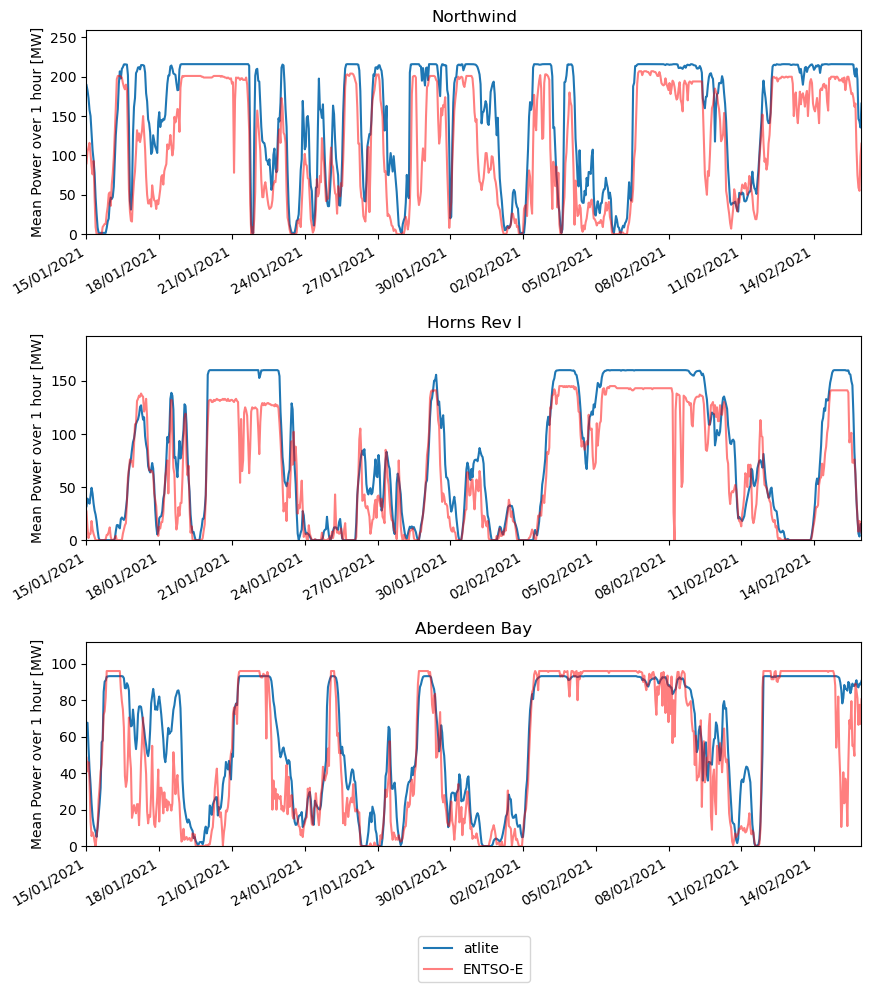

In [268]:
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates


fig, (ax2,ax3,ax4) =plt.subplots(3,1, figsize=(10,12))
#fig.suptitle('ATLITE blue vs ENTSOE red, mid of Jan 21', fontsize=14)


h1['Northwind'].plot(ax=ax2, title= 'Northwind',x_compat=True)
farms_be['Northwind'].plot(ax=ax2,color='red',alpha=0.5,x_compat=True)
ax2.set_ylim(0,h1['Northwind'].max()*1.2)

#legend options: 
#box = ax2.get_position()
#ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                 box.width, box.height * 0.9])
#
## Put a legend below current axis
#ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#          fancybox=True, shadow=True, ncol=5)

h2['Horns Rev I'].plot(ax=ax3,title='Horns Rev I',x_compat=True)
farms_dk['Horns Rev A'].plot(ax=ax3,color='red',alpha=0.5,x_compat=True)
ax3.set_ylim(0,h2['Horns Rev I'].max()*1.2)


h3['Aberdeen Offshore W/F'].plot(ax=ax4,title='Aberdeen Bay',x_compat=True)
farms_gb['ABRBO-1'].plot(ax=ax4,color='red',alpha=0.5,x_compat=True)
ax4.set_ylim(0,h3['Aberdeen Offshore W/F'].max()*1.2)

mylabels=["atlite","ENTSO-E"]
for ax in [ax2,ax3,ax4]:
    ax.set(xlabel='', ylabel='Mean Power over 1 hour [MW]') # elimante the word Timeinas Wortdex on the x-axis
    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.margins(x=0) 
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    

#assign a legend only to the last graph
pos = ax4.get_position()
ax4.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height]) 
ax4.legend(loc='lower center', bbox_to_anchor=(0.5, -0.7),labels=mylabels)  



plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


plt.savefig("../figures/atlite_entsoe_comparison.pdf", format="pdf", bbox_inches="tight")


**Plotting every timestamps on equilateral axes**

Text(0.5, 0, 'ENTSO-E values [MW]')

Text(0, 0.5, 'atlite values [MW]')

Text(0.5, 0, 'ENTSO-E values [MW]')

Text(0, 0.5, 'atlite values [MW]')

Text(0.5, 0, 'ENTSO-E values [MW]')

Text(0, 0.5, 'atlite values [MW]')

Text(0.5, 1.0, 'Northwind')

(0.0, 216.0)

(0.0, 216.0)

Text(0.5, 1.0, 'Horns Rev I')

(0.0, 160.0)

(0.0, 160.0)

Text(0.5, 1.0, 'Aberdeen Bay')

(0.0, 93.2)

(0.0, 93.2)

array([-20.,   0.,  20.,  40.,  60.,  80., 100.])

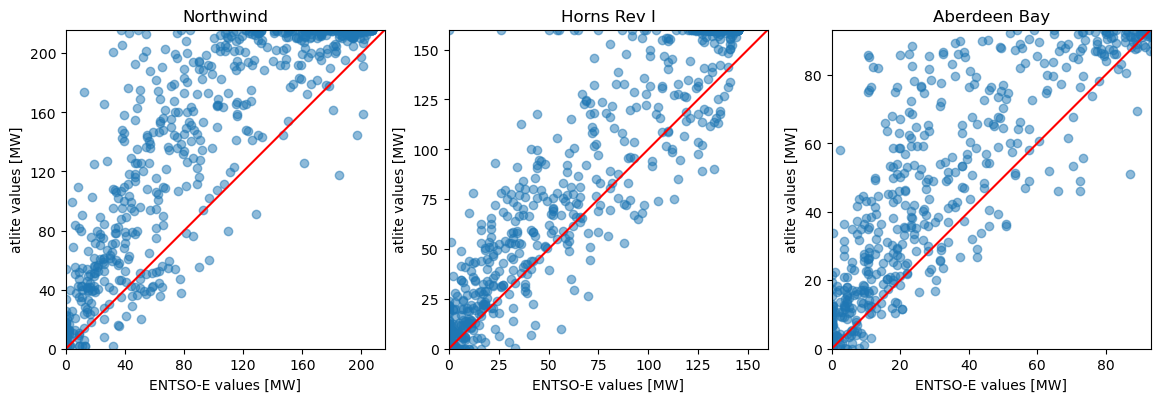

In [269]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


fig, (ax2,ax3,ax4) =plt.subplots(1,3, figsize=(14,5)) #warum fehlen die Timestamps als Label?
#fig.suptitle('Scatterplots that pair actual and projected generation for every timestamp ', fontsize=16)


for ax in fig.get_axes():
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line) 
    ax.set_xlabel('ENTSO-E values [MW]')
    ax.set_ylabel('atlite values [MW]')
    ax.set_aspect('equal', 'box')

#40,25 and 20 are the tickdistances for the three plots
for ax,b in zip( fig.get_axes(),[40,25,20] ): 
    ax.xaxis.set_major_locator(MultipleLocator(b))
    ax.yaxis.set_major_locator(MultipleLocator(b))


x2= farms_be['Northwind']
y2= h1['Northwind']
scat2= ax2.scatter(x2, y2,alpha=0.5)
ax2.set_title('Northwind')
ax2.set_xlim(0,y2.max()) #if we use set_aspect, this is not necessary
ax2.set_ylim(0,y2.max())





x3= farms_dk['Horns Rev A']
y3= h2['Horns Rev I']

scat3= ax3.scatter(x3, y3#,c=z3
                   , alpha=0.5)

ax3.set_title('Horns Rev I')
ax3.set_xlim(0,y3.max())
ax3.set_ylim(0,y3.max())


x4= farms_gb['ABRBO-1']
y4= h3['Aberdeen Offshore W/F']

scat4= ax4.scatter(x4, y4#,c=z4
                   , alpha=0.5)
ax4.set_title('Aberdeen Bay')
ax4.set_xlim(0,y4.max())
ax4.set_ylim(0,y4.max())
ax4.get_xticks()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
plt.savefig("../figures/atlite_entsoe_deviation.pdf", format="pdf", bbox_inches="tight")


# Exclusion Zones

**Taking the Cutoutgrids coordinates from above and turning them into a polygon**
<br> Some used shapefiles:
- helper : the countries' coasts merged <br>
- coast1 : reduced to the cutout <br>
- coast2 : a shapefile that is the negative thus constitues the north sea <br>
- poly: by defintion as big as the computed cutout


In [270]:
country_bound.total_bounds


array([-4.375, 50.875, 10.125, 60.875])

'The delimitations of the cutout.grid are the boundaries of our analysis'

array([-4.375, 50.875, 10.125, 60.875])

Countries  \
0     Netherlands   
1  United Kingdom   
2          France   
3         Belgium   
4         Germany   
5         Denmark   
6          Norway   

                                                                                                                                                geometry  
0  MULTIPOLYGON (((7.19747 53.21662, 7.19851 53.20058, 7.19541 53.18500, 7.18858 53.16779, 7.17442 53.14578, 7.17194 53.13771, 7.17267 53.12575, 7.17...  
1  MULTIPOLYGON (((-6.25585 55.21088, -6.23982 55.20832, -6.21764 55.21039, -6.17955 55.21971, -6.16002 55.22191, -6.12084 55.21784, -6.10098 55.2123...  
2  POLYGON ((2.53703 51.06461, 2.54706 51.02048, 2.55698 51.00118, 2.59274 50.97611, 2.60845 50.96113, 2.61165 50.94123, 2.60576 50.93524, 2.58272 50...  
3  POLYGON ((2.54200 51.09687, 2.57993 51.10480, 2.71567 51.16950, 2.92359 51.24649, 3.12485 51.32966, 3.34897 51.37515, 3.34941 51.37522, 3.35807 51...  
4  MULTIPOLYGON (((6.35044 50.41687, 6.35117 50.43356, 6.34734 50.43697, 6.34021 50.43785, 6.33163 50.44690, 6.32616 50.45702, 6.32326 50.46602, 6.32...  
5  MULTIPOLYGON (((8.66879 54.91352, 8.66139 54.92031, 8.67482 54.94794, 8.66635 54.97333, 8.65040 54.99799, 8.64096 55.02338, 8.64479 55.05573, 8.65...  
6  MULTIPOLYGON (((11.94220 59.90203, 11.89031 59.89278, 11.87463 59.88494, 11.84959 59.87242, 11.84298 59.83842, 11.85486 59.82431, 11.88374 59.8053...

<AxesSubplot:>

<AxesSubplot:>

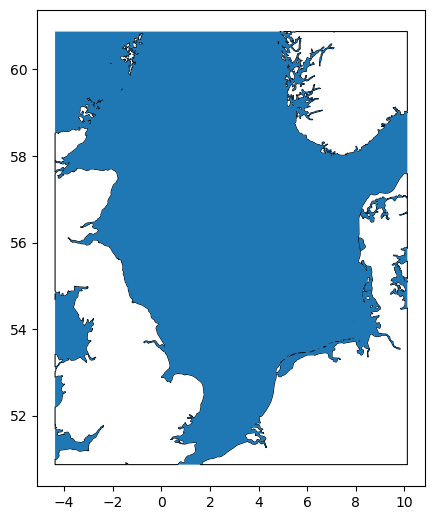

In [271]:
fig,ax = plt.subplots(figsize=(5,7))

'The delimitations of the cutout.grid are the boundaries of our analysis'
cutout.grid.total_bounds
limits= np.array([-4.375, 50.875, 10.125, 60.875])
# delimitations of the cutout grid are used to create a polygon that delimits the region of analysis
xmin, xmax= (-4.375, 10.125)
ymin, ymax= (50.875, 60.875)
lat_point_list = [ymin, ymax, ymax,ymin,ymin]
lon_point_list = [xmin, xmin ,xmax ,xmax, xmin ]
original_polygon = Polygon(zip(lon_point_list, lat_point_list))
#only 'overdefined' polygons will be correctly transformed into other CRS
#thus: create 10,000 points per line
polygon = Polygon([original_polygon.boundary.interpolate(i, normalized=True) for i in np.linspace(0, 1, 10000)])
poly = gpd.GeoDataFrame(['Outer delimitation\n same as country_bound'], geometry=[polygon], crs=4326)

helper = gpd.GeoDataFrame(geometry=BorderingStates_init.geometry).reset_index().rename(columns={'index':'Countries'})
helper.to_crs(4326)
helper= helper.clip(poly) 
inland= helper.dissolve()

coast1= inland.copy()
coast1.boundary.plot(ax=ax, zorder=1, linewidth=0.75,edgecolor='black')
coast2= poly.overlay(coast1, how='difference') #works only on dataframes, geoseries more special to work with
coast2.plot(ax=ax)




In [272]:
coast2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Import bathymetry data from GEBCO**<br>
From the documentation: The GEBCO grid can be assumed to be relative to WGS84.


In [273]:
import matplotlib.colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import rasterio
from rasterio.plot import show


gebco = rasterio.open('..\data\GEBCO\gebco_2022_n61.0_s50.75_w-5.6143_e10.6.nc')


**A depiction of the entire bathymetry data**
<br> The colormap's intervals are more finely for the area up 0 to -100 metres.

BoundingBox(left=-5.612500000000013, bottom=50.75, right=10.599999999999996, top=61.0)

array([-4.375, 50.875, 10.125, 60.875])

(-4.375, 10.125)

(50.875, 60.875)

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 25.722222222222214, 'Longitude [°]')

Text(271.63302725563045, 0.5, 'Latitude [°]')

['0', '−50', '−100', '−200', '−400', '−600', '−800', '−1000']

[Text(1, 0, '≥0'),
 Text(1, -50, '−50'),
 Text(1, -100, '−100'),
 Text(1, -200, '−200'),
 Text(1, -400, '−400'),
 Text(1, -600, '−600'),
 Text(1, -800, '−800'),
 Text(1, -1000, '≤−1000')]

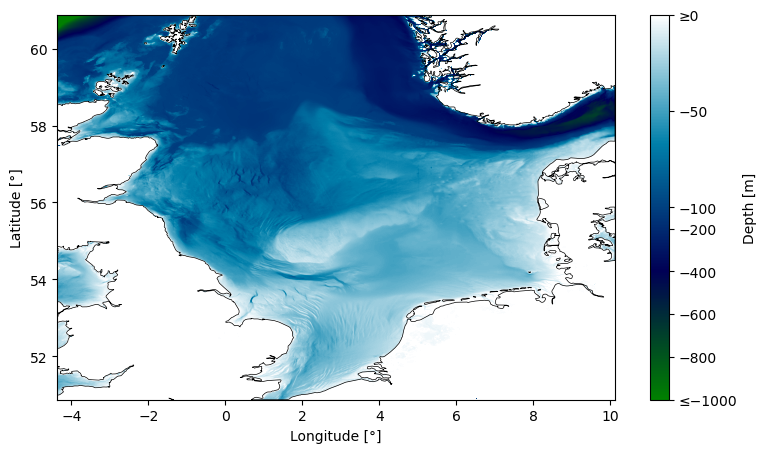

In [274]:

fig1, ax9 = plt.subplots(figsize=(9,5)) 
gebco1= gebco.read(1)

# the .tif is slightly larger than the area of analysis --> 
gebco.bounds
coast2.total_bounds
xmin,ymin,xmax,ymax =coast2.total_bounds
for axis in fig1.get_axes():
    axis.set_xlim(xmin,xmax)
    axis.set_ylim(ymin,ymax)
    coast2.plot(ax=axis,linewidth= 0.5, color='none')
    #axis.set_xlim(xmin+6.5,xmax-1) #zoom into German Bight
    #axis.set_ylim(ymin+1,ymax-2)

image2 = ax9.imshow(gebco.read()[0],cmap='ocean',norm=mpl.colors.TwoSlopeNorm(vmin=-1000,vcenter=-100,vmax=0))

fig.colorbar(image2, ax=ax9,ticks=[0,-50,-100,-200,-400, -600, -800,-1000]).set_label('Depth [m]', rotation=90)
rasterio.plot.show(gebco1,transform=gebco.transform, ax=ax9,cmap='ocean',norm=mpl.colors.TwoSlopeNorm(vmin=-1000,vcenter=-100,vmax=0))
#ax9.set_title("Sequential colormap & Intervalls Changed by TwoSlopeNorm ")
degree = u"\u00b0"
axis.set_xlabel("Longitude ["+degree+"]")
axis.set_ylabel("Latitude ["+degree+"]")


def get_colorbars(fig): #taken from https://stackoverflow.com/questions/53870706/retrieve-all-colorbars-in-figure
    cbs = []
    for ax in fig.axes:
        cbs.extend(ax.findobj(lambda obj: hasattr(obj, "colorbar") and obj.colorbar))
    return [a.colorbar for a in cbs]

#the used twoslopenorm-colorbar does not know arrows for values above and below the data range --> adding <= and >=
for cbar in get_colorbars(fig1):
    plt.draw()
    b= [l.get_text() for l in cbar.ax.get_yticklabels()]
    b
    b[0]= "≥"+b[0]
    b[-1]= "≤" + b[-1]
    cbar.ax.set_yticklabels(b)

plt.savefig("../figures/gebco_depth_map.pdf", format="pdf", bbox_inches="tight")


This plot sorts the depth values into discretes categories:

BoundingBox(left=-5.612500000000013, bottom=50.75, right=10.599999999999996, top=61.0)

array([-4.375, 50.875, 10.125, 60.875])

(-4.375, 10.125)

(50.875, 60.875)

<AxesSubplot:>

Text(0.5, 25.722222222222214, 'Longitude [°]')

Text(271.63302725563045, 0.5, 'Latitude [°]')

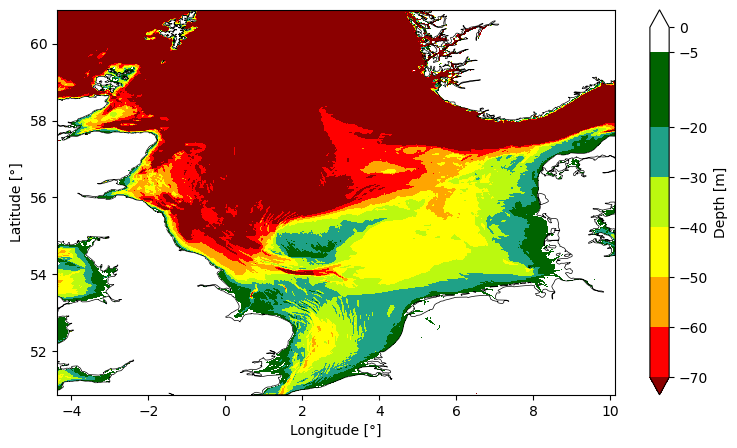

In [275]:
fig2, ax10 = plt.subplots(figsize=(9,5))
gebco1= gebco.read(1)

gebco.bounds
coast2.total_bounds
xmin,ymin,xmax,ymax =coast2.total_bounds
for axis in fig2.get_axes():
    axis.set_xlim(xmin,xmax)
    axis.set_ylim(ymin,ymax)
    coast2.plot(ax=axis,linewidth= 0.5, color='none')
    #axis.set_xlim(xmin+6.5,xmax-1) #zoom into German Bight
    #axis.set_ylim(ymin+1,ymax-2)
    

a1 = np.array([-70,-60,-50,-40,-30,-20,-5,0])
mycmap1 = matplotlib.colors.ListedColormap(
    ['red','orange','yellow','#BBF90F',[0.122312, 0.633153, 0.530398, 1.0],'darkgreen','white']
).with_extremes(over='white', under='darkred')

image= show(gebco1,transform=gebco.transform, ax=ax10,cmap=mycmap1,norm=mpl.colors.BoundaryNorm(boundaries=a1, ncolors=len(a1)-1))
im = image.get_images()[0]
fig2.colorbar(im, ax=ax10,spacing='proportional',extend='both').set_label('Depth [m]', rotation=90)
degree = u"\u00b0"
axis.set_xlabel("Longitude ["+degree+"]")
axis.set_ylabel("Latitude ["+degree+"]")

plt.savefig("../figures/gebco_admissibility_map.pdf", format="pdf", bbox_inches="tight")


#ax10.set_title("Discrete, new Colormap & Fixed Interval [-100;0] & Proportional Colorbar")



In [276]:
gebco.meta # important data on the raster data file
gebco2= gebco.read()
gebco2.shape

gebco.bounds
coast2.total_bounds


{'driver': 'netCDF',
 'dtype': 'int16',
 'nodata': -32767.0,
 'width': 3891,
 'height': 2460,
 'count': 1,
 'crs': None,
 'transform': Affine(0.004166666666666669, 0.0, -5.612500000000013,
        0.0, -0.004166666666666668, 61.0)}

(1, 2460, 3891)

BoundingBox(left=-5.612500000000013, bottom=50.75, right=10.599999999999996, top=61.0)

array([-4.375, 50.875, 10.125, 60.875])

In [277]:
n2000= gpd.read_file(r"..\data\protected_areas_shapefiles\protected_areas_N2000.gpkg")
nor = gpd.read_file(r"..\data\protected_areas_shapefiles\protected_areas_NOR.gpkg")
eng =gpd.read_file(r"..\data\protected_areas_shapefiles\protected_areas_EN.gpkg")
sco = gpd.read_file(r"..\data\protected_areas_shapefiles\protected_areas_SC.gpkg")

Later on, I will leave out the "Southern North Sea SAC", it is a protection area
https://jncc.gov.uk/our-work/southern-north-sea-mpa/, but intended for a certain type of sea mammal (harbor porpoise).
There are several exisiting windfarms in the MPA.


In [278]:
windfarm_new['STATUS'].unique()

array(['Planned', 'Production', 'Dismantled', 'Approved', 'Construction'],
      dtype=object)

In [279]:
two_norwegian_windfarms = gpd.read_file(r"..\data\Windfarm_Shapefiles_Norway\two_windfarms.gpkg")

In [280]:
military = gpd.read_file(r"..\data\EMODnet_HA_MilitaryAreas_20221216\EMODnet_HA_MilitaryAreas_20221216.gdb",mask=poly)
##mask selects shapefiles in the area of "poly", no clipping takes place

In [281]:
military= military.clip(polygon)

In [282]:
military_nor_a=gpd.read_file(r"..\data\military_areas_NOR\military_areas_NOR.gpkg",mask=poly)

In [283]:
military_nor= military_nor_a.clip(poly)

The North Sea as defined by the IHO, mask selects North Sea:

In [284]:
iho=gpd.read_file(r"C:\Users\march\Desktop\oweg-int-NSR\data\World_Seas_IHO_v3\World_Seas_IHO_v3.shp",rows=slice(87,88))

These data are all EEZs merged with sea regions. Mask selects sea parts that have a share in coast2-extent, no clipping at this point:

In [285]:
iho_eez=gpd.read_file( r"C:\Users\march\Desktop\oweg-int-NSR\data\Intersect_EEZ_IHO_v4_2020\Intersect_EEZ_IHO_v4_2020.shp",mask=coast2.geometry)

In [286]:
iho_initial= iho.copy()
iho= gpd.overlay(iho, poly,how='intersection')

<AxesSubplot:>

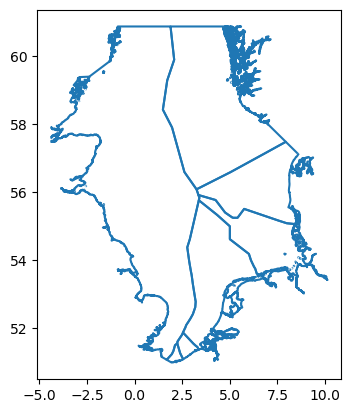

In [287]:
#index may only be set after clipping, otherwise it disappears
iho_eez=gpd.overlay(iho_eez[iho_eez['IHO_SEA']=='North Sea'],poly, how='intersection')
iho_eez=iho_eez.set_index("MARREGION") 
iho_eez.boundary.plot()

In [288]:
iho_eez.AREA_KM2

MARREGION
Belgian part of the North Sea             3495
Danish part of the North Sea             49717
Dutch part of the North Sea              64328
French part of the North Sea              1750
German part of the North Sea             41334
Norwegian part of the North Sea         119489
United Kingdom part of the North Sea    247106
Name: AREA_KM2, dtype: int64

**Creating the cells that serve as level of analysis**
<br> without maritime borders, there were 1430 cells, now there are 1584 due to the diagonal maritime borders

<AxesSubplot:>

1584

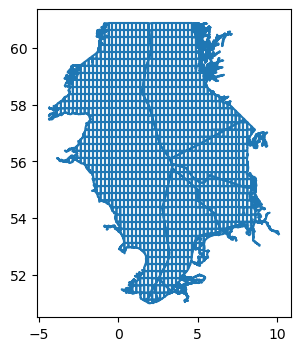

In [289]:
new_grid=cutout.grid.overlay(iho_eez.reset_index(),how='intersection')

fig,ax= plt.subplots(figsize=(4,4))
new_grid.boundary.plot(ax=ax)
len(new_grid)


Illustrating the population cells

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 102.72222222222219, 'Longitude [°]')

Text(309.24085354028574, 0.5, 'Latitude [°]')

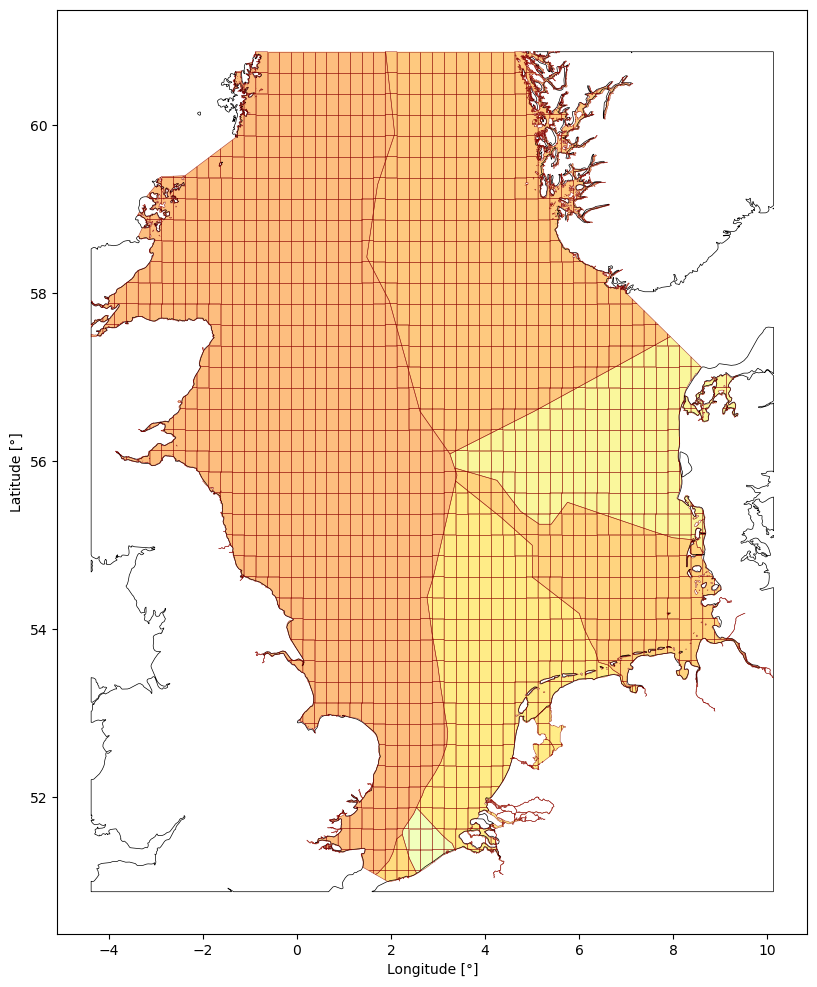

In [290]:
from shapely.geometry import LineString
xmin,ymin,xmax,ymax =coast2.total_bounds



fig,ax=plt.subplots(figsize=(14,12))
coast1.boundary.plot(ax=ax,color='black',linewidth=0.5)

#'this returns a clipped polygon without the overhang, because iho_eez was edited above
iho_eez[iho_eez['IHO_SEA']=='North Sea'].plot(ax=ax,cmap='Wistia',alpha=0.5)
new_grid.boundary.plot(ax=ax,color='darkred',linewidth= 0.4,alpha=0.7)

ax.set_xlabel("Longitude ["+degree+"]")
ax.set_ylabel("Latitude ["+degree+"]")
##if you want to show that this is a Pseude Plate Carree projection:
#ax.set_aspect('equal', 'box')

#zoom into German Bight, to see differences between coast2 and iho_eez in coastal lines
#ax.set_xlim(xmin+9,xmax) #zoom into German Bight
#ax.set_ylim(ymin+1,ymax-5)

plt.savefig("../figures/region_of_analysis.pdf", format="pdf", bbox_inches="tight")


Illustrating the difference between the shapefiles

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 80.7222222222222, 'Longitude [°]')

Text(284.0587925249697, 0.5, 'Latitude [°]')

<AxesSubplot:xlabel='Longitude [°]', ylabel='Latitude [°]'>

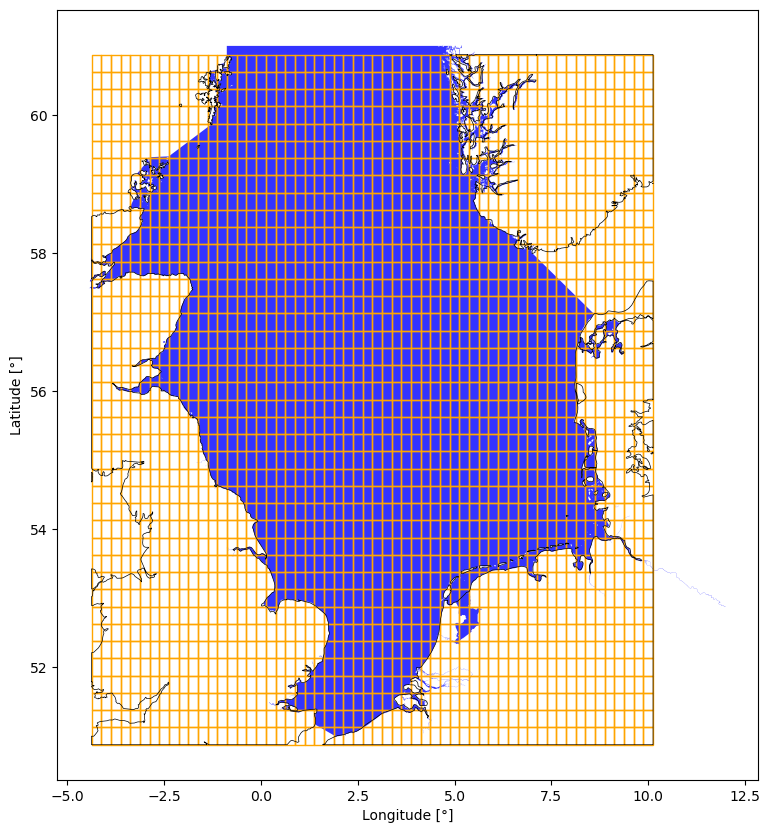

In [291]:
from shapely.geometry import LineString
xmin,ymin,xmax,ymax =coast2.total_bounds

fig,ax=plt.subplots(figsize=(13,10))
coast1.boundary.plot(ax=ax,color='black',linewidth=0.5)

#this returns a clipped polygon without the overhang, because iho_eez was edited above
iho_initial.plot(ax=ax,color='blue',alpha=0.8)

ax.set_xlabel("Longitude ["+degree+"]")
ax.set_ylabel("Latitude ["+degree+"]")
cutout.grid.plot(color='none',edgecolor='orange',ax=ax,zorder=1)


##zoom into German Bight, to see differences between coast2 and iho_eez in coastal lines

#ax.set_xlim(xmin+9,xmax) #zoom into German Bight
#ax.set_ylim(ymin+1,ymax-5)

plt.savefig("../figures/ERA5_cells_and_IHO.pdf", format="pdf", bbox_inches="tight")


**Depiction of Shipping Routes**

32708.0

0.0

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

11520

<AxesSubplot:>

(3159200.0, 4808100.0)

(2828000.0, 4482600.0)

Text(0.5, 0, 'Easting Value [m]')

Text(0, 0.5, 'Northing Value [m]')

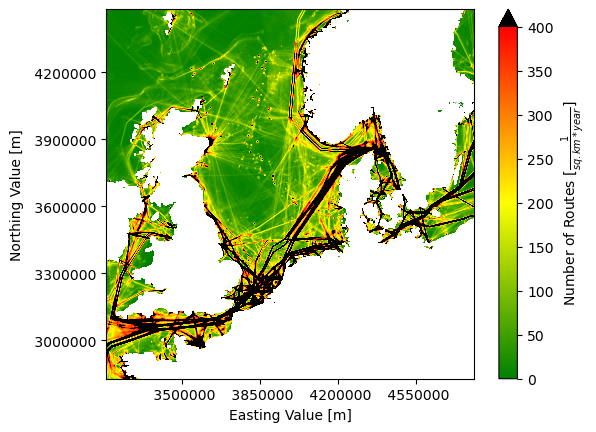

In [292]:
path="../data/EMODnet_HA_EMSA_Route_Density_all_2019-2022_Yearly/wid1000006-all_traffic-all_europe-yearly-20220101000000_20221231235959-tdm-grid.tif"
routes = rasterio.open(path)

routes1= routes.read(1)

routes1= np.where(routes1==-9999,np.nan,routes1) # change all nodata values into np.nan #otherwise strange depiction of the border areas
routes1= np.where((routes1==1.0)+routes1<0 ,np.nan,routes1) # changing all values that are exactly 1.0 and those below zero to np.nan

unique, counts = np.unique(routes1, return_counts=True)
np.nanmax(routes1)
np.nanmin(routes1)
routes1
len(np.unique(routes1))


fig,ax =plt.subplots()

cmap = LinearSegmentedColormap.from_list('name', ['green', 'yellow', 'red']).with_extremes(over='0', under='0.75')
#0 und 0.75 are color values for the arrow tips

rasterio.plot.show(routes1,transform=routes.transform,cmap=cmap,vmax=400,ax=ax)

#coast2.to_crs(3035).plot(ax=ax,color='red',alpha= 0.3)
#iho.to_crs(3035).plot(ax=ax,color='none',edgecolor='blue',zorder=0)

image_hidden= ax.imshow(routes1, cmap=cmap,vmax=400)

dot= u'\u22c5' 
fig.colorbar(image_hidden,extend='max',ax=ax).set_label('Number of Routes ['+ r'$\frac{1}{sq. km * year}$'+']', rotation=90) #die Farben dafür wurden in cmap definiert, max, both, min

image_hidden.set_visible(False)

ax.set_xlim(3159200.0, 4808100.0)
ax.set_ylim(2828000.0, 4482600.0)


ax.set_xlabel("Easting Value [m]")
ax.set_ylabel("Northing Value [m]")

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))
ax.xaxis.set_major_locator(MultipleLocator(350000))
ax.yaxis.set_major_locator(MultipleLocator(300000))


plt.savefig("../figures/route_density.pdf", format="pdf", bbox_inches="tight")

In [293]:
routes.transform
gebco.transform

Affine(1000.0, 0.0, -623000.0,
       0.0, -1000.0, 7035000.0)

Affine(0.004166666666666669, 0.0, -5.612500000000013,
       0.0, -0.004166666666666668, 61.0)

**Plotting the areas that are to be excluded from the analysis**

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 102.72222222222219, 'Easting Value [m]')

Text(287.3204906155106, 0.5, 'Northing Value [m]')

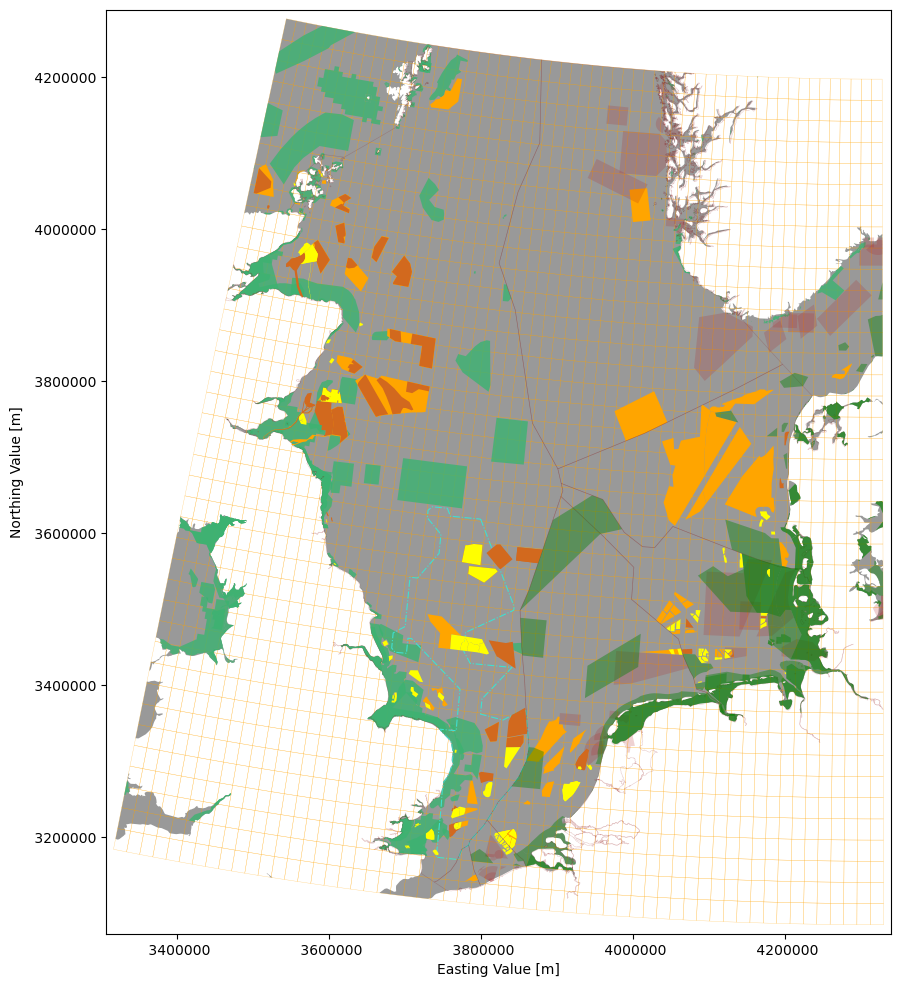

In [294]:

coast3 = coast2.to_crs(3035)


fig,ax =plt.subplots(1,figsize=(14,12))
n2000.plot(ax=ax,color='green',zorder=7, alpha=0.4)
cutout.grid.to_crs(3035).plot(ax=ax,alpha=0.5,color='none',edgecolor='orange',linewidth=0.25)

coast3.plot(ax=ax,color='grey',alpha=0.8,zorder=0) #shapefile of the water surface within the cutout area
windfarm_new[(windfarm_new['STATUS']== 'Production')  | (windfarm_new['STATUS']=='Construction')].to_crs(3035).plot(ax=ax, color='yellow',zorder=7)
windfarm_new[windfarm_new['STATUS']=='Approved'].to_crs(3035).plot(ax=ax, color='chocolate',zorder=6)
windfarm_new[windfarm_new['STATUS']=='Planned'].to_crs(3035).plot(ax=ax, color='orange',zorder=3)
windfarm_new[windfarm_new['STATUS']=='Dismantled'].to_crs(3035).plot(ax=ax, color='violet')


#the Norwegian ones are in planning phase
two_norwegian_windfarms.to_crs(3035).plot(ax=ax, color='orange')

nor.to_crs(3035).plot(ax=ax,color = 'mediumseagreen',alpha=0.8)
eng.drop(297).to_crs(3035).plot(ax=ax,color = 'mediumseagreen',alpha=0.8)
sco.to_crs(3035).plot(ax=ax,color = 'mediumseagreen', alpha=0.8)
eng.iloc[[297]].boundary.to_crs(3035).plot(ax=ax, color='turquoise',linestyle="dashdot",linewidth=0.8,zorder=1)

military.to_crs(3035).plot(ax=ax,color = 'firebrick', alpha=0.2)
military_nor.to_crs(3035).plot(ax=ax,color= 'firebrick',alpha=0.2)
iho_eez.boundary.to_crs(3035).plot(ax=ax,color='darkred',linewidth= 0.4,alpha=0.2,zorder=1)

##for zooming in:
#xmin,ymin,xmax,ymax =coast3.total_bounds
#for axis in fig.get_axes():
#    axis.set_xlim(3.9*10**6,xmax)
#    axis.set_ylim(ymin,3.8*10**6)

ax.set_xlabel("Easting Value [m]")
ax.set_ylabel("Northing Value [m]")



ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))
ax.margins(x=0.01,y=0.01)


plt.savefig("../figures/excluded_areas.png", format="png", bbox_inches="tight")


In [295]:
windfarm_new.index = windfarm_new.index.astype("int64")
windfarm_new.head()


OBJECTID         COUNTRY                     NAME  N_TURBINES  POWER_MW  \
0         7  United Kingdom              Brough Ness          66      99.0   
1         8  United Kingdom        Brims Tidal Array         200     200.0   
2         9  United Kingdom              Brough Head          50      50.0   
3        10  United Kingdom      EMEC Stronsay Firth           0       0.0   
4        11  United Kingdom  Firth of Forth Met Mast           1       0.0   

       STATUS  YEAR    COAST_DIST  AREA_SQKM NOTES  Shape_Leng  Shape_Area  0  \
0     Planned     0    262.104684   2.990592  None    0.139683    0.000463  1   
1     Planned     0    410.971295  11.033219  None    0.317197    0.001711  1   
2     Planned     0      0.000000  24.109619  None    0.934577    0.003776  1   
3     Planned     0     67.060704  23.702008  None    0.265971    0.003709  1   
4  Production     0  29720.434705   0.010007  None    0.005055    0.000001  1   

                                                                                                                                                geometry  
0  POLYGON ((-2.94334 58.71778, -2.96177 58.72249, -2.96200 58.72680, -2.94560 58.72796, -2.93040 58.72956, -2.92926 58.72983, -2.92519 58.73079, -2....  
1  POLYGON ((-3.17420 58.74915, -3.22048 58.75411, -3.29183 58.75331, -3.30968 58.76548, -3.31163 58.76649, -3.31269 58.76730, -3.31281 58.76808, -3....  
2  POLYGON ((-3.21105 59.15359, -3.21109 59.15359, -3.21111 59.15360, -3.21112 59.15360, -3.21114 59.15360, -3.21116 59.15360, -3.21119 59.15360, -3....  
3                                              POLYGON ((-2.69836 59.09376, -2.67836 59.05042, -2.77837 59.04626, -2.77837 59.08376, -2.69836 59.09376))  
4                                              POLYGON ((-1.97318 56.61116, -1.97316 56.61205, -1.97153 56.61204, -1.97155 56.61114, -1.97318 56.61116))

**Exclusion based on shapefiles with ATLITE for FOW**

No new windfarms of any kind closer than 13 km to the coast:

In [296]:
min_distance= coast1.to_crs(3035).buffer(13000) # buffer in a UTM-PCRS is in meteres --> 13 km minimum distance for new windfarms

In [297]:
from atlite.gis import ExclusionContainer
excluder_fow = ExclusionContainer(crs=3035)

from atlite.gis import shape_availability


#To be excluded:
#are in EPSG 4326, are converted automatically
excluder_fow.add_geometry(n2000)
excluder_fow.add_geometry(nor)
excluder_fow.add_geometry(eng.drop(297))
excluder_fow.add_geometry(sco)

#no new windfarms closer than 13 km:
excluder_fow.add_geometry(min_distance)

#decomissioned wind farms are so tiny that i will not exclude them sepaerately
excluder_fow.add_geometry(windfarm_new)

excluder_fow.add_geometry(two_norwegian_windfarms)
excluder_fow.add_geometry(military_nor)

excluder_fow.add_geometry(military)


#adapted from https://github.com/PyPSA/pypsa-eur/blob/master/scripts/build_renewable_profiles.py

##maximum depth
#func = functools.partial(np.greater, -50) # maximum depth
##minimum depth
#func = functools.partial(np.less, -50)

#allowing only a range for the construction:
def myfunc(new,new1,x): ##x is traversed, the first two arguments are plugged in for all iterations) 
    #x must be at the end of the brackets
    return ((x < new) | (x > new1) ) 
func = functools.partial(myfunc, -1000,-50.1)


excluder_fow.add_raster(r"..\data\GEBCO\gebco_2022_n61.0_s50.75_w-5.6143_e10.6.tif", codes=func, crs=4326, nodata=-1000)

#Shipping
func_shipping = functools.partial(np.less, 300)
excluder_fow.add_raster(r"..\data\EMODnet_HA_EMSA_Route_Density_all_2019-2022_Yearly\wid6-all_traffic-all_europe-yearly-20210101000000_20211231235959-tdm-grid.tif",codes=func_shipping, crs=3035)



**And analogously for fixed-bottom with different depths**

In [298]:
excluder_fb = ExclusionContainer(crs=3035)

shape = iho_eez.geometry.to_crs(3035) 

#To be excluded:
#are in EPSG 4326, are converted automatically
excluder_fb.add_geometry(n2000) 
excluder_fb.add_geometry(nor)
excluder_fb.add_geometry(eng.drop(297))
excluder_fb.add_geometry(sco)

#no new windfarms closer than 13 km:
excluder_fb.add_geometry(min_distance)

#decomissioned are so tiny that i will not exclude them sepaerately
excluder_fb.add_geometry(windfarm_new)

#1405
excluder_fb.add_geometry(two_norwegian_windfarms)
excluder_fb.add_geometry(military_nor)

excluder_fb.add_geometry(military)

#adapted from https://github.com/PyPSA/pypsa-eur/blob/master/scripts/build_renewable_profiles.py

def myfunc(new,new1,x): 
    return ((x < new) | (x > new1) ) 
func = functools.partial(myfunc, -50,-5) 

excluder_fb.add_raster(r"..\data\GEBCO\gebco_2022_n61.0_s50.75_w-5.6143_e10.6.tif", codes=func, crs=4326, nodata=-1000)

#Shipping
func_shipping = functools.partial(np.less, 300)
excluder_fb.add_raster(r"..\data\EMODnet_HA_EMSA_Route_Density_all_2019-2022_Yearly\wid6-all_traffic-all_europe-yearly-20210101000000_20211231235959-tdm-grid.tif",codes=func_shipping, crs=3035)



Position of cutout centroids in the Nort Sea

<AxesSubplot:>

<AxesSubplot:>

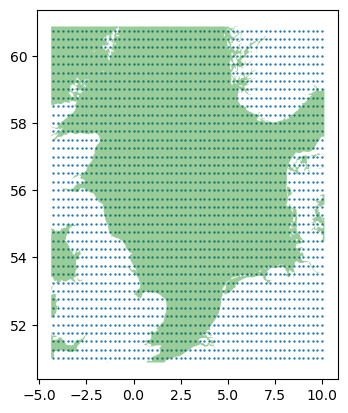

In [299]:
fig,ax= plt.subplots()
cutout.grid.centroid.plot(ax=ax, markersize=0.5)
coast2.plot(color='green', alpha=0.4,ax=ax)

In [300]:
cutout.grid.total_bounds ==poly.total_bounds

array([ True,  True,  True,  True])

All cells are mutually exclusive, there are no overlaps

In [301]:
#for i in range(len(new_grid)):
#    new_grid.iloc[[i]].overlaps(new_grid.drop(i)).any()

Counting is from bottom left to top right within each EEZ

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

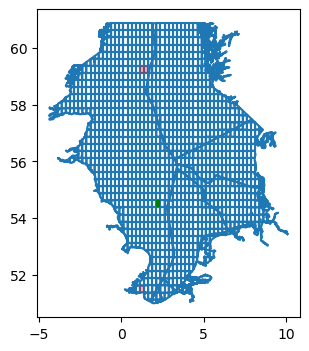

In [302]:
fig,ax= plt.subplots(figsize=(4,4))
new_grid.boundary.plot(ax=ax)
new_grid.iloc[582:584].plot(zorder=9,ax=ax, color= "red", alpha=.3)
new_grid.iloc[13:14].plot(zorder=9,ax=ax, color= "red", alpha=.3)
new_grid.iloc[[158]].plot(zorder=9,ax=ax, color= "green")


This prepares the units of analysis for the time series calculation and determines the level of aggregation of time series data.
<br> Here, 1584 individuals are the level of analysis/ the population:

In [303]:
shape=new_grid.geometry.to_crs(3035)

**Create exclusion mask and availability matrix for FOW**

In [304]:
mask_fow, transform_fow = shape_availability(shape, excluder_fow)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 80.7222222222222, 'Easting Value [m]')

Text(250.28327921662913, 0.5, 'Northing Value [m]')

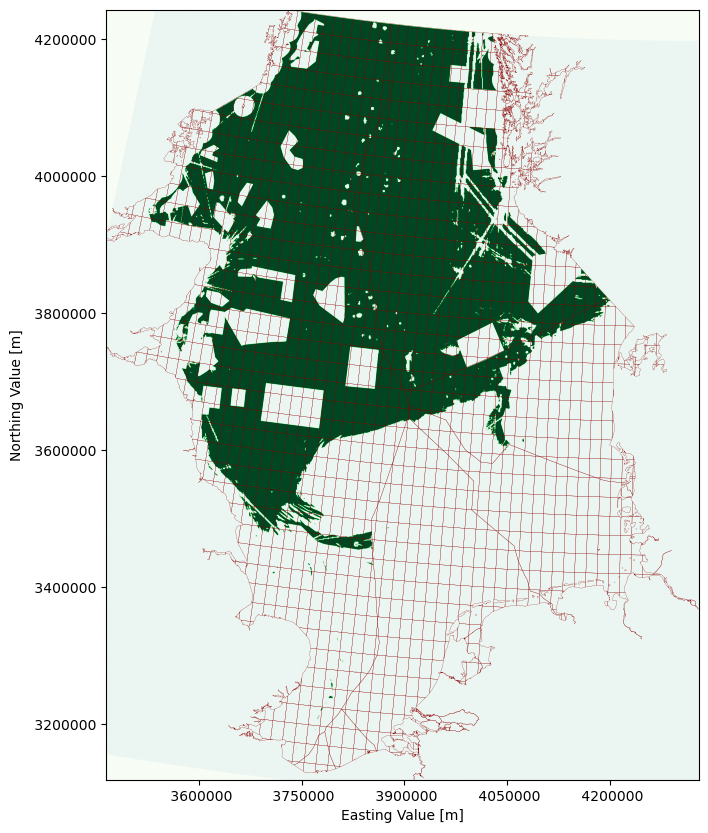

In [305]:
fig, ax = plt.subplots(figsize=(12,10)) 
cells.to_crs(3035).plot(ax=ax,alpha=0.05) 
shape.boundary.plot(ax=ax, color='darkred',linewidth=0.15) #plots the cell's boundaries
show(mask_fow, transform=transform_fow, cmap='Greens', ax=ax)

ax.set_xlabel("Easting Value [m]")
ax.set_ylabel("Northing Value [m]")

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))

ax.xaxis.set_major_locator(MultipleLocator(150000))
plt.savefig("../figures/exclusion_mask_fow.pdf", format="pdf", bbox_inches="tight")



<br>"Calculations takes 1:50 h, therefore xarray has been saved as A_fow for floating wind offshore"
<br>  Only xarray.Dataset objects can be written to netCDF files, so the xarray.DataArray is converted to a xarray.Dataset object containing a single variable. If the DataArray has no name, or if the name is the same as a coordinate name, then it is given the name "__xarray_dataarray_variable__".

In [306]:
if os.path.isfile(r"..\data\availability_matrix\A_fow.nc"):
    'Opening the stored-data'
    B= xr.open_dataset(r"..\data\availability_matrix\A_fow.nc")
    A_fow= B["__xarray_dataarray_variable__"]
else: 
    'Calculating the availabilty map. This takes roughly 1:34 h'
    A_fow = cutout.availabilitymatrix(shape, excluder_fow)
    A_fow.to_netcdf(path= r"..\data\availability_matrix\A_fow.nc",format="NETCDF4")

'Opening the stored-data'

In [307]:
A_fow

<xarray.DataArray '__xarray_dataarray_variable__' (dim_0: 1584, y: 40, x: 58)>
[3674880 values with dtype=float64]
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 ... 1577 1578 1579 1580 1581 1582 1583
  * y        (y) float64 51.0 51.25 51.5 51.75 52.0 ... 60.0 60.25 60.5 60.75
  * x        (x) float64 -4.25 -4.0 -3.75 -3.5 -3.25 ... 9.0 9.25 9.5 9.75 10.0

**Create exclusion mask and availability matrx for fixed-bottom WTGs**

In [308]:
mask_fb, transform_fb = shape_availability(shape, excluder_fb)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 80.7222222222222, 'Easting Value [m]')

Text(250.28327921662913, 0.5, 'Northing Value [m]')

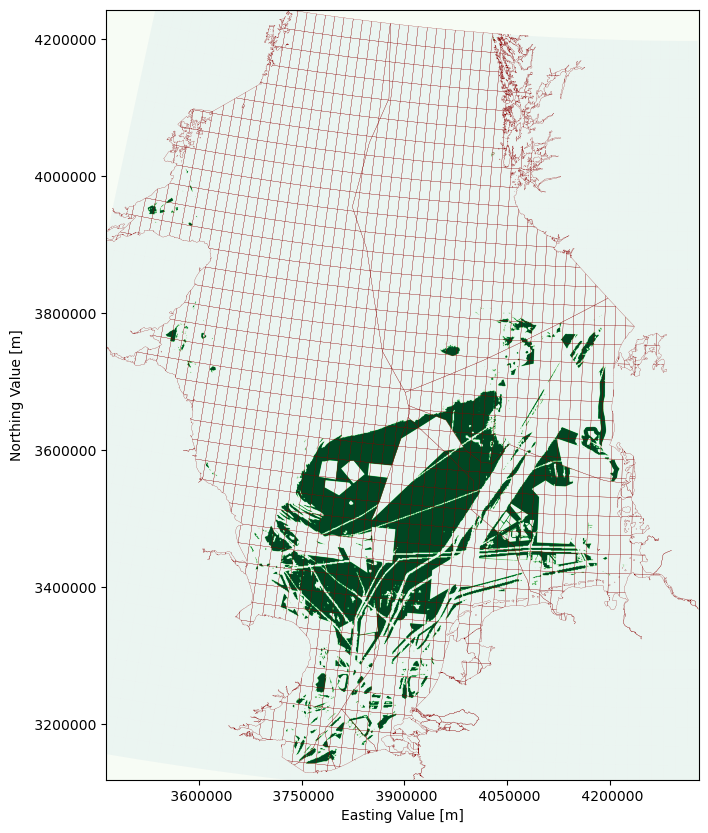

In [309]:
fig, ax = plt.subplots(figsize=(12,10)) 
cells.to_crs(3035).plot(ax=ax,alpha=0.05)

shape.boundary.plot(ax=ax, color='darkred',linewidth=0.15) #plots the cells' boundaries
show(mask_fb, transform=transform_fb, cmap='Greens', ax=ax)


ax.set_xlabel("Easting Value [m]")
ax.set_ylabel("Northing Value [m]")

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.0f'))

ax.xaxis.set_major_locator(MultipleLocator(150000))
plt.savefig("../figures/exclusion_mask_fb.pdf", format="pdf", bbox_inches="tight")



#transform ist schon nötig, damit die Achsen stimmen

In [310]:
if os.path.isfile(r"..\data\availability_matrix\A_fb.nc"):
    'Opening the stored-data'
    B= xr.open_dataset(r"..\data\availability_matrix\A_fb.nc")
    A_fb= B["__xarray_dataarray_variable__"]
else: 
    'Calculating the availabilty map. This takes roughly xx h'
    A_fb = cutout.availabilitymatrix(shape, excluder_fb)
    A_fb.to_netcdf(path= r"..\data\availability_matrix\A_fb.nc",format="NETCDF4")

'Opening the stored-data'

All individual 1584 matrices are not named, they will threfore be selected via .sel()/.isel() from the "dim_0"-xarray.

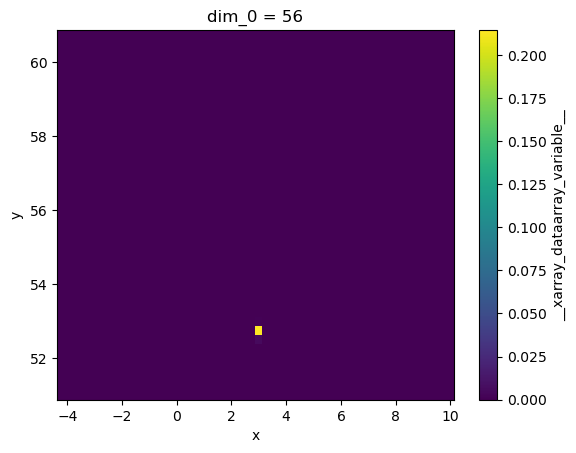

In [311]:
A_fb.sel(dim_0 = 56).plot()

**Depiction of the individual celles and their individual percentage of availability plotted as colormap**

<AxesSubplot:title={'center':'dim_0 = 120'}, xlabel='x', ylabel='y'>

<AxesSubplot:title={'center':'dim_0 = 120'}, xlabel='x', ylabel='y'>

<AxesSubplot:title={'center':'dim_0 = 120'}, xlabel='x', ylabel='y'>

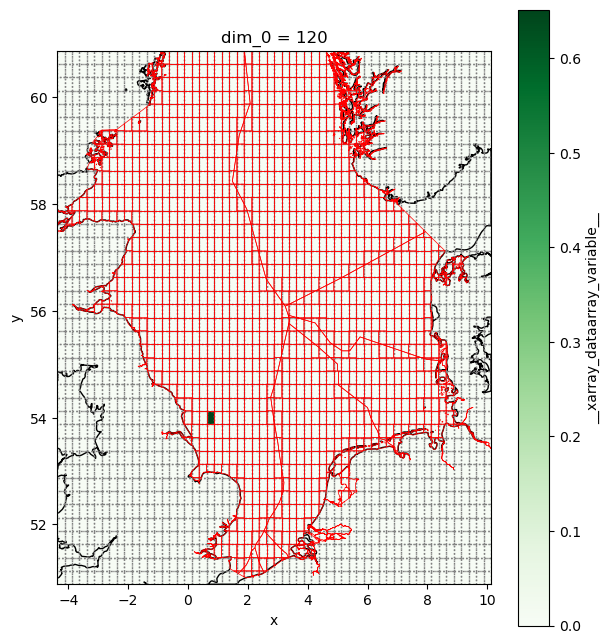

In [312]:
fig, ax = plt.subplots(figsize=(7,8))
A_fb.sel(dim_0 =120).plot(cmap="Greens",ax=ax) 
coast2.plot(ax=ax, edgecolor="k", color="None")
new_grid.boundary.plot(ax=ax,color='red',linewidth= 0.5)
cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")

The xarray dim_0 hold 2320 matrices (one for each cutout cell, even inland cells), each matrix has 1584 entries for the EEZ cells. These hold only one single value above zero.

In [313]:
A_fb.isel(dim_0=14).values.shape

(40, 58)

The availabilites for alle cells combined:

<AxesSubplot:xlabel='x', ylabel='y'>

<AxesSubplot:xlabel='x', ylabel='y'>

<AxesSubplot:xlabel='x', ylabel='y'>

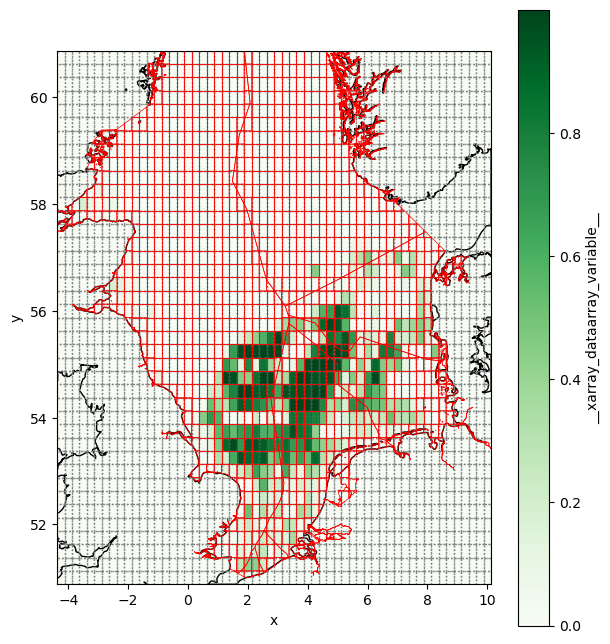

In [314]:
fig, ax = plt.subplots(figsize=(7,8))
A_fb.sum("dim_0").plot(ax=ax,cmap="Greens")
coast2.plot(ax=ax, edgecolor="k", color="None")
new_grid.boundary.plot(ax=ax,color='red',linewidth= 0.5)
cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")
plt.savefig("../figures/availability_matrix_fb.pdf", format="pdf", bbox_inches="tight")


<AxesSubplot:xlabel='x', ylabel='y'>

<AxesSubplot:xlabel='x', ylabel='y'>

<AxesSubplot:xlabel='x', ylabel='y'>

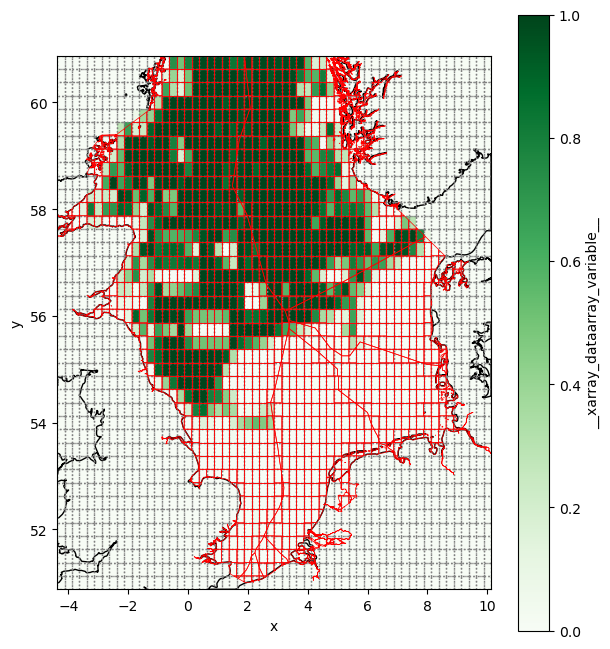

In [315]:
fig, ax = plt.subplots(figsize=(7,8))
A_fow.sum("dim_0").plot(ax=ax,cmap="Greens")
coast2.plot(ax=ax, edgecolor="k", color="None")
new_grid.boundary.plot(ax=ax,color='red',linewidth= 0.5)
cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")
plt.savefig("../figures/availability_matrix_fow.pdf", format="pdf", bbox_inches="tight")

**Calculating the average capacity density for fixed-bottom WTGs based on current projects**
<br> Numerator in MW, denominator in sq.km

In [316]:
#France:
#Dunkirk wind farm
french_mean= 600/float(50)

#Belgium: 
#noordhinder Noord + Noordhinder zuid+ Fairybank akak Princess Elisabeth I - III
belgian_mean= (700 /float(46.0) + 1400/float(103.0) + 1400/ float(106.8) )/ 3

#The Netherlands:
#Hollandse Kuist (nord) Site V + Site VI-VII Hollandse kuist )west together
dutch_mean= (759/ 126.4   +1400/176.0)/2

#UK:
#Dogger Bank South (West) +Dogger Bank South (East) + Outer Dowsing
uk_mean= (1500/494.89 + 1500/493.58 + 1500/499.62) /3

#DK:
#Thor +Vesterhav Syd +Vesterhav Nord
danish_mean= (1008/440 + 168/37.0 + 176/40)/3

#Germany:
#N-3.5, N-3.6, N-6.6, N-6.7, N-11.1, N-12.1, N.12.2, O-2.2
german_mean= np.array([8.8,9.9,9.6,5.7,8.3,8.7,9.1,7.3]).mean()

#Norway:
#only one windfarm in upcoming tendering process
norwegian_mean = 3000/float(2591)

In [317]:
value_list=[
belgian_mean,
danish_mean,
french_mean,
german_mean,
dutch_mean,
norwegian_mean,
uk_mean]
values_rounded = [round(i,2) for i in value_list]

In [318]:
values_rounded

[13.97, 3.74, 12.0, 8.43, 6.98, 1.16, 3.02]

**Setting the capacity density for fixed-bottom WTGs**

In [319]:
len([np.NaN]*len(new_grid))
new_grid_try =new_grid.copy()
new_grid_try.insert(12,"cap_density_fb", [np.NaN]*len(new_grid))

1584

In [320]:
new_grid_try.MARREGION.unique()
new_grid_try["cap_density_fb"]
def assign_cap(df):
    if df["MARREGION"] == 'United Kingdom part of the North Sea':
        df.cap_density_fb = round(uk_mean,2)
        return df
    elif df["MARREGION"] == 'French part of the North Sea':
        df.cap_density_fb = round(french_mean,2)
        return df
    elif df["MARREGION"] == 'Belgian part of the North Sea':
        df.cap_density_fb = round(belgian_mean,2)
        return df
    elif df["MARREGION"] == 'Dutch part of the North Sea':
        df.cap_density_fb = round(dutch_mean,2)
        return df
    elif df["MARREGION"] == 'German part of the North Sea':
        df.cap_density_fb = round(german_mean,2)
        return df
    elif df["MARREGION"] == 'Danish part of the North Sea':
        df.cap_density_fb = round(danish_mean,2)
        return df
    elif df["MARREGION"]== 'Norwegian part of the North Sea':
        df.cap_density_fb = round(norwegian_mean,2)
        return df


array(['United Kingdom part of the North Sea',
       'French part of the North Sea', 'Belgian part of the North Sea',
       'Dutch part of the North Sea', 'German part of the North Sea',
       'Danish part of the North Sea', 'Norwegian part of the North Sea'],
      dtype=object)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1579   NaN
1580   NaN
1581   NaN
1582   NaN
1583   NaN
Name: cap_density_fb, Length: 1584, dtype: float64

In [321]:
new_grid_try=new_grid_try.apply(assign_cap,axis=1)

**Setting the capacity density for FOW to a uniform value**

In [322]:
new_grid_try.insert(13,"cap_density_fow", 5)
#source: https://ore.catapult.org.uk/wp-content/uploads/2021/03/AIPaper_ScotWind_Predictions_FINAL.pdf in Schottland anvisiert


In [323]:
#make sure, range of values was pased correctly
new_grid_try.cap_density_fb.value_counts()
new_grid_try.MARREGION.value_counts()


3.02     678
1.16     367
6.98     205
3.74     162
8.43     145
13.97     17
12.00     10
Name: cap_density_fb, dtype: int64

United Kingdom part of the North Sea    678
Norwegian part of the North Sea         367
Dutch part of the North Sea             205
Danish part of the North Sea            162
German part of the North Sea            145
Belgian part of the North Sea            17
French part of the North Sea             10
Name: MARREGION, dtype: int64

In [324]:
area = cutout.grid.set_index(["y", "x"])
area1= area.to_crs(3035).area / 1e6 # calculate the area for each cutout cell
area2= xr.DataArray(area1, dims=("spatial")) 
area2

<xarray.DataArray (spatial: 2320)>
array([488.08381941, 488.08381966, 488.08381991, ..., 379.76372209,
       379.76372209, 379.76372209])
Coordinates:
  * spatial  (spatial) MultiIndex
  - y        (spatial) float64 51.0 51.0 51.0 51.0 ... 60.75 60.75 60.75 60.75
  - x        (spatial) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0

In [325]:
# multiply availability matrix with cell area
capacity_matrix_fb = A_fb.stack(spatial=["y", "x"]) * area2

capacity_matrix_fb

capacity_matrix_fow = A_fow.stack(spatial=["y", "x"]) * area2

capacity_matrix_fow

for i, c in enumerate(new_grid_try.index):
    capacity_matrix_fb[i][:] = capacity_matrix_fb[i][:] * new_grid_try['cap_density_fb'].iloc[i]
    
for i, c in enumerate(new_grid_try.index):
    capacity_matrix_fow[i][:] = capacity_matrix_fow[i][:] * new_grid_try['cap_density_fow'].iloc[i]


<xarray.DataArray (dim_0: 1584, spatial: 2320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 ... 1577 1578 1579 1580 1581 1582 1583
  * spatial  (spatial) MultiIndex
  - y        (spatial) float64 51.0 51.0 51.0 51.0 ... 60.75 60.75 60.75 60.75
  - x        (spatial) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0

<xarray.DataArray (dim_0: 1584, spatial: 2320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 ... 1577 1578 1579 1580 1581 1582 1583
  * spatial  (spatial) MultiIndex
  - y        (spatial) float64 51.0 51.0 51.0 51.0 ... 60.75 60.75 60.75 60.75
  - x        (spatial) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0

In [326]:
capacity_matrix_fow.shape
#plotting an individual cell
#capacity_matrix_fow.isel(dim_0=188).unstack().plot()

(1584, 2320)

**Result: Two capacity matrices: for Fixed-Bottom and for FOW**

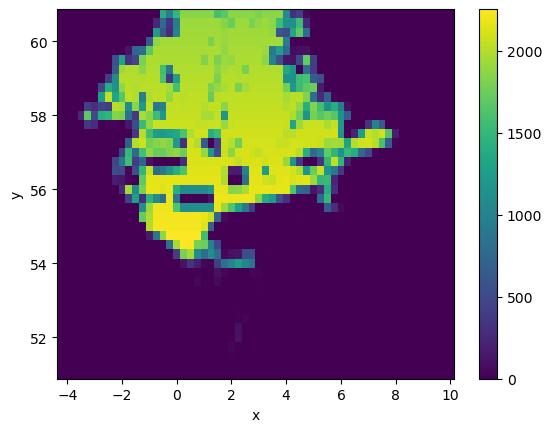

In [327]:
capacity_matrix_fow.unstack().sum("dim_0").plot() 

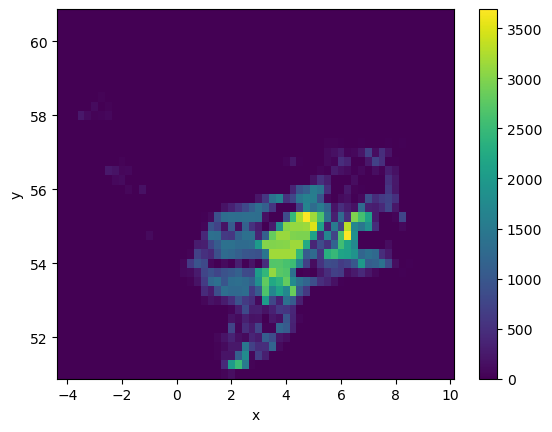

In [328]:
capacity_matrix_fb.unstack().sum("dim_0").plot()

**Calculating the yield for FOW**

In [329]:
power_fow = yield_cutout.wind(atlite.windturbines['NREL_ReferenceTurbine_2020ATB_15MW_offshore'],matrix=capacity_matrix_fow,index= new_grid.index) 

#power_fow.to_pandas().div(1e3).plot(ylabel="Wind Generation [GW]", ls="--", figsize=(10, 4));

#transform into GWh
p_fow = power_fow.to_pandas().div(1e3)


INFO:atlite.convert:Convert and aggregate 'wind'.


Set wake losses according to TU Denmark's assumptions of generated energy <br>
https://static.agora-energiewende.de/fileadmin/Projekte/2019/Offshore_Potentials/176_A-EW_A-VW_Offshore-Potentials_Publication_WEB.pdf

All FOW are assumed to have a capacity density of 5 MW/sqkm, ergo just on wake loss percentage.

In [330]:
for i in np.arange(0,len(p_fow.columns),1):
       p_fow.iloc[:,i] = p_fow.iloc[:,i] * (1-0.246)
    

**Yearly generation for FOW:**

In [331]:
yield_val_fow= p_fow.sum(axis=0)


In [332]:
yield_map_fow= new_grid.copy()
yield_map_fow =yield_map_fow.assign(yield_vals_fow=yield_val_fow)
#yield_map_fow.columns

**Plotting the yearly yield for FOW**

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 80.7222222222222, 'Longitude [°]')

Text(162.9698447058173, 0.5, 'Latitude [°]')

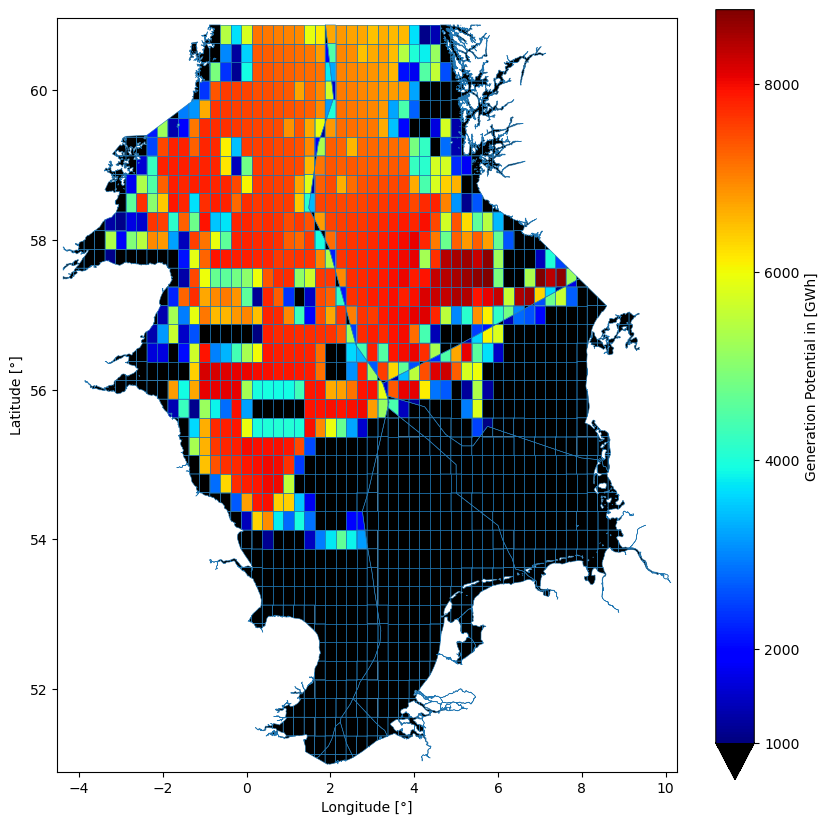

In [333]:
fig,ax= plt.subplots(figsize=(10,10))
new_grid.boundary.plot(linewidth=0.4,ax=ax)

#I want to use the matplotlib functionality extend, therefore I must set legend=False in the.plot-command
cmap3 = mpl.cm.get_cmap('jet')
cmap3.set_under('black')
yield_map_fow.plot(column='yield_vals_fow',ax=ax,cmap=cmap3, vmin=1000,legend=False)#, vmin=1500, legend=False, markersize=50)

stored_data = ax.collections[-1]
fig.colorbar(stored_data,cmap=cmap3,ax=ax, extend='min',ticks=[1000,2000,4000,6000,8000,10000,11500]).set_label('Generation Potential in [GWh]', rotation=90)

ax.set_xlabel("Longitude ["+degree+"]")
ax.set_ylabel("Latitude ["+degree+"]")
ax.margins(x=0.01,y=0.01)

plt.savefig("../figures/yield_map_fow.pdf", format="pdf", bbox_inches="tight")



**Calculating the yield for FB**

In [334]:
power_fb = yield_cutout.wind(atlite.windturbines['NREL_ReferenceTurbine_2020ATB_15MW_offshore'],matrix=capacity_matrix_fb,index= new_grid.index) 

#powerfb.to_pandas().div(1e3).plot(ylabel="Wind Generation [GW]", ls="--", figsize=(10, 4));

#transform into GWh
p_fb = power_fb.to_pandas().div(1e3)


INFO:atlite.convert:Convert and aggregate 'wind'.


Set wake losses according to TU Denmark's assumptions of generated energy <br>
https://static.agora-energiewende.de/fileadmin/Projekte/2019/Offshore_Potentials/176_A-EW_A-VW_Offshore-Potentials_Publication_WEB.pdf

In [335]:
for i in np.arange(0,len(p_fb.columns),1):
    if i <= 677: #United Kingdom part of the North Sea', #3.02
        p_fb.iloc[:,i] = p_fb.iloc[:,i] * (1-0.246)
    elif i >=678 and i <=687:  #'French part of the North Sea' #12
        p_fb.iloc[:,i] = p_fb.iloc[:,i] * (1-0.46)
        
    elif i >=688 and i <= 704:  #'Belgian part of the North Sea' #13.97
        p_fb.iloc[:,i] = p_fb.iloc[:,i] * (1-0.46)
    elif i >=705 and i <= 909:  #'Dutch part of the North Sea' #6.98
        p_fb.iloc[:,i] = p_fb.iloc[:,i] * (1-0.333)
    elif i >=910 and i <= 1054:     #'German part of the North Sea' .8.43
        p_fb.iloc[:,i] = p_fb.iloc[:,i] *(1-0.333)
    
    elif i >=1055 and i <= 1216:        #'Danish part of the North Sea, #3.74
        p_fb.iloc[:,i] = p_fb.iloc[:,i] *(1-0.246)
    elif i >=1217:
        p_fb.iloc[:,i] = p_fb.iloc[:,i] *(1-0.246) #1.16
        #'Norwegian part of the North Sea'
    


**Yearly generation for Fixed-Bottom**

In [336]:
yield_val_fb= p_fb.sum(axis=0)

In [337]:
yield_val_fb

dim_0
0        6.128932
1       46.069698
2        0.000000
3        0.000000
4        0.000000
          ...    
1579    22.385453
1580     0.000000
1581     0.000000
1582     0.000000
1583     0.000000
Length: 1584, dtype: float64

In [338]:
yield_map_fb= new_grid.copy()
yield_map_fb =yield_map_fb.assign(yield_vals_fb=yield_val_fb)

In [339]:
yield_map_fb.columns

Index([            'x',             'y',     'MARREGION',           'fid',
               'MRGID',     'MRGID_IHO',       'IHO_SEA',     'MRGID_EEZ',
                 'EEZ',    'MRGID_TER1',    'TERRITORY1',      'ISO_TER1',
             'UN_TER1',    'MRGID_SOV1',    'SOVEREIGN1',      'ISO_SOV1',
             'UN_SOV1',    'MRGID_TER2',    'TERRITORY2',      'ISO_TER2',
             'UN_TER2',    'MRGID_SOV2',    'SOVEREIGN2',      'ISO_SOV2',
             'UN_SOV2',    'MRGID_TER3',    'TERRITORY3',      'ISO_TER3',
             'UN_TER3',    'MRGID_SOV3',    'SOVEREIGN3',      'ISO_SOV3',
             'UN_SOV3',      'AREA_KM2',           'X_1',           'Y_1',
                     0,      'geometry', 'yield_vals_fb'],
      dtype='object')

**Plotting the yearly yield for Fixed-Bottom**

I want to use the matplotlib functionality extend, therefore I must set legend=False in the.plot-command

In [340]:
yield_map_fb['yield_vals_fb'].max()

12450.952115304119

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 80.7222222222222, 'Longitude [°]')

Text(162.9698447058173, 0.5, 'Latitude [°]')

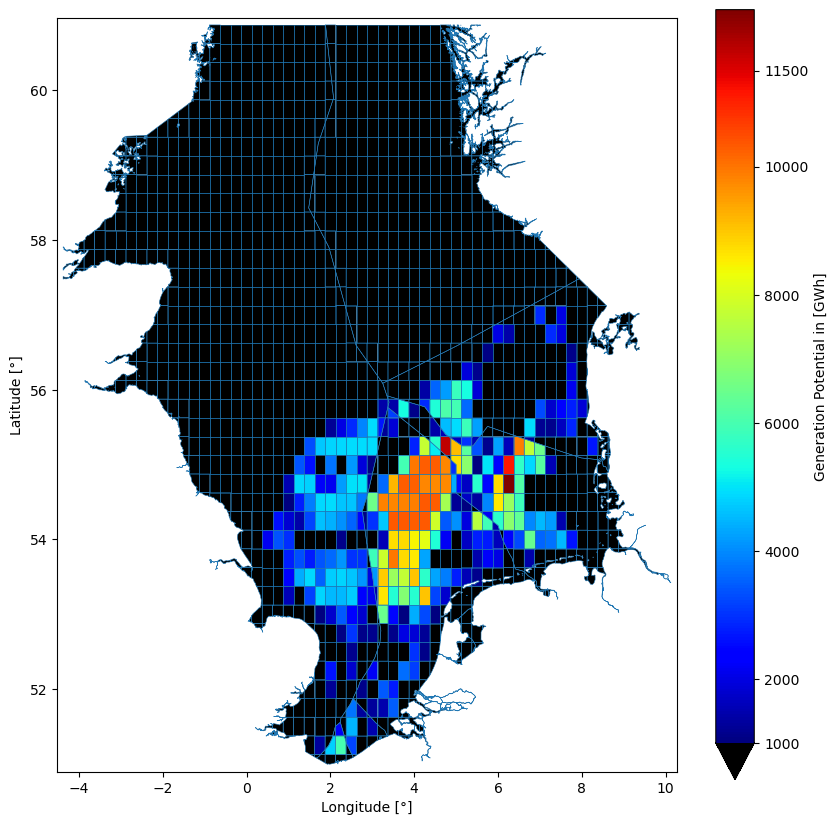

In [341]:
fig,ax= plt.subplots(figsize=(10,10))
new_grid.boundary.plot(linewidth=0.4,ax=ax)
#cmap3 os from above
yield_map_fb.plot(column='yield_vals_fb',ax=ax,cmap=cmap3, vmin=1000,legend=False)

#plt.colorbar(yield_map_fow['yield_vals_fow'],extend='max',ax=ax).set_label('Number of Routes ['+ r'$\frac{1}{sq. km * year}$'+']', rotation=90)
#kw = dict(orientation='vertical', extend='both')
#cbar = plt.colorbar(cmap='jet', ax=ax, **kw)


stored_data_1 = ax.collections[-1]
fig.colorbar(stored_data_1,cmap=cmap3,ax=ax, extend='min',ticks=[1000,2000,4000,6000,8000,10000,11500]).set_label('Generation Potential in [GWh]', rotation=90)

ax.set_xlabel("Longitude ["+degree+"]")
ax.set_ylabel("Latitude ["+degree+"]")
ax.margins(x=0.01,y=0.01)
#fig.colorbar(image_hidden,extend='max',ax=ax).set_label('Number of Routes ['+ r'$\frac{1}{sq. km * year}$'+']', rotation=90) #die Farben dafür wurden in cmap definiert, max, both, min

#so kann man cbar-Orientierung ändern
#cax = divider.append_axes("bottom", size="5%", pad=0.1)


plt.savefig("../figures/yield_map_fb.pdf", format="pdf", bbox_inches="tight")


In [342]:
yield_map_fb.head()

x      y                             MARREGION    fid  MRGID  MRGID_IHO  \
0  1.50  51.00  United Kingdom part of the North Sea  538.0  25235       2350   
1  1.75  51.00  United Kingdom part of the North Sea  538.0  25235       2350   
2  0.50  51.25  United Kingdom part of the North Sea  538.0  25235       2350   
3  0.75  51.25  United Kingdom part of the North Sea  538.0  25235       2350   
4  1.00  51.25  United Kingdom part of the North Sea  538.0  25235       2350   

     IHO_SEA  MRGID_EEZ                                     EEZ  MRGID_TER1  \
0  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
1  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
2  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
3  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
4  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   

   ... MRGID_SOV3 SOVEREIGN3  ISO_SOV3  UN_SOV3 AREA_KM2      X_1       Y_1  \
0  ...          0       None      None        0   247106  0.33018  56.68868   
1  ...          0       None      None        0   247106  0.33018  56.68868   
2  ...          0       None      None        0   247106  0.33018  56.68868   
3  ...          0       None      None        0   247106  0.33018  56.68868   
4  ...          0       None      None        0   247106  0.33018  56.68868   

                                            0  \
0  Outer delimitation\n same as country_bound   
1  Outer delimitation\n same as country_bound   
2  Outer delimitation\n same as country_bound   
3  Outer delimitation\n same as country_bound   
4  Outer delimitation\n same as country_bound   

                                                                                                                                                geometry  \
0                                                   POLYGON ((1.62500 51.12500, 1.62500 51.09407, 1.55315 51.11725, 1.52913 51.12500, 1.62500 51.12500))   
1               POLYGON ((1.62500 51.12500, 1.76678 51.12500, 1.72528 51.09944, 1.66880 51.07993, 1.62870 51.09287, 1.62500 51.09407, 1.62500 51.12500))   
2  POLYGON ((0.47577 51.37500, 0.47449 51.37460, 0.47348 51.37424, 0.47228 51.37410, 0.47102 51.37392, 0.46954 51.37369, 0.46813 51.37343, 0.46699 51...   
3  POLYGON ((0.87500 51.35426, 0.87482 51.35429, 0.87406 51.35443, 0.87319 51.35457, 0.87214 51.35470, 0.87111 51.35484, 0.87003 51.35494, 0.86959 51...   
4  POLYGON ((1.12500 51.37500, 1.12500 51.37312, 1.12407 51.37299, 1.12330 51.37284, 1.12275 51.37270, 1.12222 51.37256, 1.12158 51.37242, 1.12092 51...   

  yield_vals_fb  
0      6.128932  
1     46.069698  
2      0.000000  
3      0.000000  
4      0.000000  

[5 rows x 39 columns]

**Adding the distances and mean of depths to the yield_fow_df**

heatmap based on distance to shore and based on water depth

In [343]:
point_set= gpd.GeoDataFrame(data= new_grid[['x','y']],geometry=new_grid.centroid.geometry,crs=4326)
point_set=point_set.to_crs(3035)
point_set['distance_to_landfall']= point_set['geometry'].apply(lambda p: coast1.boundary.to_crs(3035).distance(p))

In [344]:
new_grid.iloc[[0]]

x     y                             MARREGION    fid  MRGID  MRGID_IHO  \
0  1.5  51.0  United Kingdom part of the North Sea  538.0  25235       2350   

     IHO_SEA  MRGID_EEZ                                     EEZ  MRGID_TER1  \
0  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   

   ... UN_TER3 MRGID_SOV3  SOVEREIGN3  ISO_SOV3 UN_SOV3 AREA_KM2      X_1  \
0  ...       0          0        None      None       0   247106  0.33018   

        Y_1                                           0  \
0  56.68868  Outer delimitation\n same as country_bound   

                                                                                               geometry  
0  POLYGON ((1.62500 51.12500, 1.62500 51.09407, 1.55315 51.11725, 1.52913 51.12500, 1.62500 51.12500))  

[1 rows x 38 columns]

In [345]:
def point_finder(x):
    from shapely.ops import nearest_points
    p1, p0 = nearest_points(coast1.to_crs(3035).iloc[0].geometry, x) #x ist bereits ein centroid in point_set 
    #coast1 hat nur ein element, iloc ist nötig, weil sonst eoseries has no argument geom_" kommt)
    return p1 #das ist der landepunkt an der Küste
    

In [346]:
point_set['landfall']= point_set['geometry'].apply(point_finder)

Some points on the coast are the landfalls for multiple cells

In [347]:
point_set['landfall'].value_counts()[:5]

POINT (3664400.815 3490859.260)    50
POINT (3618299.024 3876995.120)    50
POINT (3590870.586 3668116.116)    44
POINT (4200726.312 3606526.856)    32
POINT (4067238.817 3946359.276)    32
Name: landfall, dtype: int64

In [348]:
b= point_set['landfall'].value_counts().index.to_list()[:10]
#extracting the top receiving points and plot them as green dots

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 24.0, 'Longitude [°]')

Text(24.0, 0.5, 'Latitude [°]')

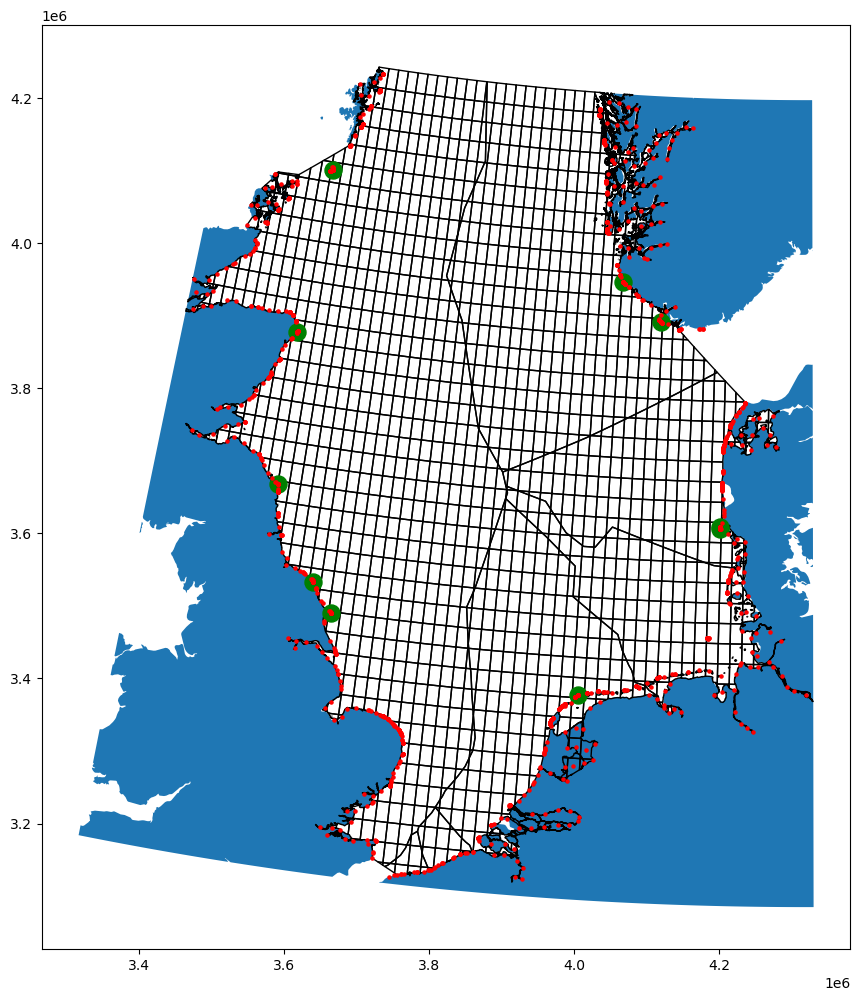

In [349]:
fig,ax= plt.subplots(figsize=(12,12))
#points.plot(ax=ax,color='red',zorder=8,markersize=0.3)
coast1.to_crs(3035).plot(ax=ax)
point_set['landfall'].plot(ax=ax,color='red',zorder=2,markersize=5)
new_grid.to_crs(3035).plot(ax=ax,color='none')

pu = gpd.GeoDataFrame(geometry=b,crs=3035)
pu.plot(ax=ax, color='green',zorder=1,markersize=150)
#ax.set_xlim(3159200.0, 4258100.0)
#ax.set_ylim(3258000.0, 3682600.0)
axis.set_xlabel("Longitude ["+degree+"]")
axis.set_ylabel("Latitude ["+degree+"]")


Some centroid points are in the inland, represented by coast1. Reason: the IHO file regards more surface as North Sea that the file coast1, for example th IJsselmeer. As a result, "sea" areas exist within the country borders. Their distance to shore is 0 in these cases. 
<br> Green points indicate points, that are the ending point of the shortest distance for multiple cells.

In [350]:
point_set.head()

x      y                         geometry  distance_to_landfall  \
0  1.50  51.00  POINT (3733796.442 3145320.216)          15073.443214   
1  1.75  51.00  POINT (3739872.551 3143833.820)          18053.802336   
2  0.50  51.25  POINT (3659581.431 3183634.876)           7230.108594   
3  0.75  51.25  POINT (3683385.884 3179216.150)            192.463769   
4  1.00  51.25  POINT (3694689.559 3177641.709)           1166.363595   

                          landfall  
0  POINT (3720556.357 3152524.995)  
1  POINT (3745222.754 3126590.993)  
2  POINT (3659581.431 3183634.876)  
3  POINT (3683340.286 3179029.166)  
4  POINT (3694897.106 3176493.960)

In [351]:
yield_map_fb.columns

Index([            'x',             'y',     'MARREGION',           'fid',
               'MRGID',     'MRGID_IHO',       'IHO_SEA',     'MRGID_EEZ',
                 'EEZ',    'MRGID_TER1',    'TERRITORY1',      'ISO_TER1',
             'UN_TER1',    'MRGID_SOV1',    'SOVEREIGN1',      'ISO_SOV1',
             'UN_SOV1',    'MRGID_TER2',    'TERRITORY2',      'ISO_TER2',
             'UN_TER2',    'MRGID_SOV2',    'SOVEREIGN2',      'ISO_SOV2',
             'UN_SOV2',    'MRGID_TER3',    'TERRITORY3',      'ISO_TER3',
             'UN_TER3',    'MRGID_SOV3',    'SOVEREIGN3',      'ISO_SOV3',
             'UN_SOV3',      'AREA_KM2',           'X_1',           'Y_1',
                     0,      'geometry', 'yield_vals_fb'],
      dtype='object')

In [352]:
yield_map_fb.insert(yield_map_fb.shape[1],'landfall', point_set['landfall'])
yield_map_fow.insert(yield_map_fow.shape[1],'landfall', point_set['landfall'])


In [353]:
yield_map_fb.insert(yield_map_fb.shape[1],'distance_to_landfall', point_set['distance_to_landfall'])
yield_map_fow.insert(yield_map_fow.shape[1],'distance_to_landfall', point_set['distance_to_landfall'])

**Rasterstats**

In [354]:
from rasterstats import zonal_stats
stats=zonal_stats(new_grid,'..\data\GEBCO\gebco_2022_n61.0_s50.75_w-5.6143_e10.6.tif', stats="count min mean max median")


In [355]:
(stats[1])

type(stats[1])
type(stats[1]['mean'])

{'min': -40.0,
 'max': -31.0,
 'mean': -35.58091286307054,
 'count': 241,
 'median': -36.0}

dict

float

In [356]:
#luckily, the new_grid- file clipped inland values
z=[]
for i in range(len(stats)): #i is for some reason regarded as a dictionary
    z.append(stats[i]['min'])

point_set['mean_depth']= z
    

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 24.0, 'Longitude [°]')

Text(24.0, 0.5, 'Latitude [°]')

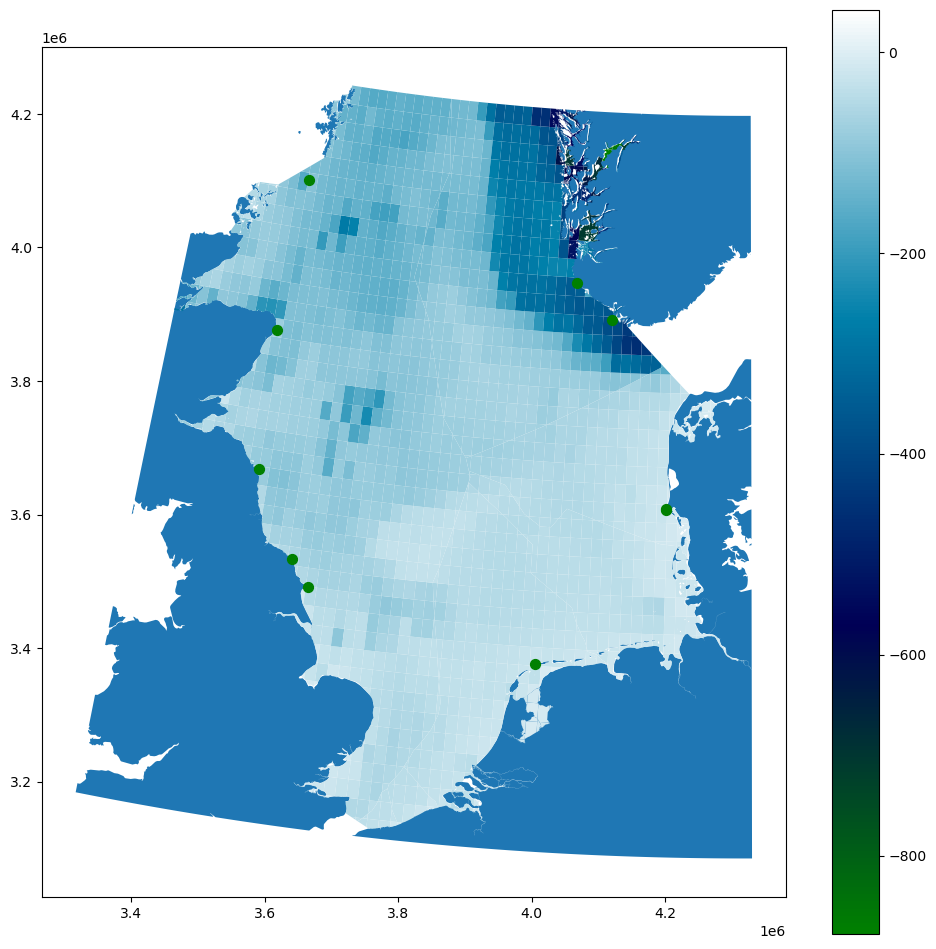

In [357]:
point_set_new= point_set
point_set_new['geometry']=new_grid.to_crs(3035)['geometry']
fig,ax= plt.subplots(figsize=(12,12))
#points.plot(ax=ax,color='red',zorder=8,markersize=0.3)
coast1.to_crs(3035).plot(ax=ax)
point_set.plot(ax=ax,column='mean_depth',cmap='ocean',legend=True) #bei geopandas mittlerweile da drin, anders bei rasterio
#new_grid.to_crs(3035).plot(ax=ax,color='none')

pu = gpd.GeoDataFrame(geometry=b,crs=3035)
pu.plot(ax=ax, color='green',zorder=1,markersize=50)

axis.set_xlabel("Longitude ["+degree+"]")
axis.set_ylabel("Latitude ["+degree+"]")


Outliers which define the minimum depth below -800m are Norwegian rivers and fjords. 

In [358]:
yield_map_fb.insert(yield_map_fb.shape[1],'mean_depth',point_set['mean_depth'])
yield_map_fow.insert(yield_map_fow.shape[1],'mean_depth', point_set['mean_depth'])


In [359]:
yield_map_fb.columns== yield_map_fow.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True])

**Both curves sorted by yield, starting with the largest observation**

In [360]:
yield_curve_fow= yield_map_fow.sort_values(by='yield_vals_fow',ascending=False)
yield_curve_fb= yield_map_fb.sort_values(by='yield_vals_fb',ascending=False)


Eliminating low-yield cells

In [361]:
ind_fow= yield_curve_fow.reset_index()
(ind_fow["yield_vals_fow"]>10).value_counts()
ind_fow = ind_fow[ind_fow["yield_vals_fow"]>50] #elimante low-yield regions

ind_fb= yield_curve_fb.reset_index()
(ind_fb["yield_vals_fb"]>10).value_counts()
ind_fb = ind_fb[ind_fb["yield_vals_fb"]>50] #elimante low-yield regions

True     861
False    723
Name: yield_vals_fow, dtype: int64

False    1060
True      524
Name: yield_vals_fb, dtype: int64

There are many low-yield cells, mainly those that have been excluded by the availability. This applies both to FB and FOW. Note that many coastal cells like rivers and fjords have been excluded by the 13-km-rule.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Grid Cells Sorted by Yield Values in Descending Order')

Text(0, 0.5, 'Yield in [GWh]')

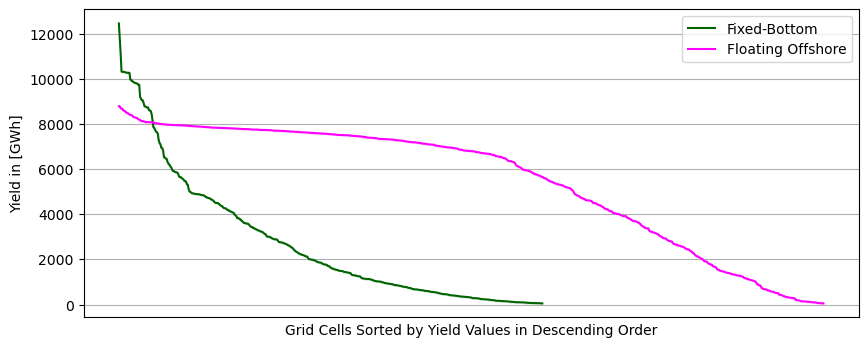

In [362]:
#plt.plot(ind_fow['index'].astype(str),ind_fow['yield_vals_fow'], '-o',markersize= .04)


fig,ax=plt.subplots(figsize=(10,4))
ax.plot(ind_fb.index.astype(str),ind_fb['yield_vals_fb'], '-o',markersize= .04,c='darkgreen')
ax.plot(ind_fow.index.astype(str),ind_fow['yield_vals_fow'], '-o',markersize= .04,c='magenta')

#plt.gca().get_xaxis().set_visible(False)
ax.legend(labels=['Fixed-Bottom','Floating Offshore'])
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.label1.set_visible(False)
#ax.set_xticklabels([])
plt.grid(axis='y')
ax.set_xlabel("Grid Cells Sorted by Yield Values in Descending Order")
ax.set_ylabel("Yield in [GWh]")

plt.savefig("../figures/sorted_yield_curves.pdf", format="pdf", bbox_inches="tight")



In [363]:
yield_map_fow.head()

x      y                             MARREGION    fid  MRGID  MRGID_IHO  \
0  1.50  51.00  United Kingdom part of the North Sea  538.0  25235       2350   
1  1.75  51.00  United Kingdom part of the North Sea  538.0  25235       2350   
2  0.50  51.25  United Kingdom part of the North Sea  538.0  25235       2350   
3  0.75  51.25  United Kingdom part of the North Sea  538.0  25235       2350   
4  1.00  51.25  United Kingdom part of the North Sea  538.0  25235       2350   

     IHO_SEA  MRGID_EEZ                                     EEZ  MRGID_TER1  \
0  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
1  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
2  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
3  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   
4  North Sea       5696  United Kingdom Exclusive Economic Zone        2208   

   ... UN_SOV3 AREA_KM2      X_1       Y_1  \
0  ...       0   247106  0.33018  56.68868   
1  ...       0   247106  0.33018  56.68868   
2  ...       0   247106  0.33018  56.68868   
3  ...       0   247106  0.33018  56.68868   
4  ...       0   247106  0.33018  56.68868   

                                            0  \
0  Outer delimitation\n same as country_bound   
1  Outer delimitation\n same as country_bound   
2  Outer delimitation\n same as country_bound   
3  Outer delimitation\n same as country_bound   
4  Outer delimitation\n same as country_bound   

                                                                                                                                                geometry  \
0                                                   POLYGON ((1.62500 51.12500, 1.62500 51.09407, 1.55315 51.11725, 1.52913 51.12500, 1.62500 51.12500))   
1               POLYGON ((1.62500 51.12500, 1.76678 51.12500, 1.72528 51.09944, 1.66880 51.07993, 1.62870 51.09287, 1.62500 51.09407, 1.62500 51.12500))   
2  POLYGON ((0.47577 51.37500, 0.47449 51.37460, 0.47348 51.37424, 0.47228 51.37410, 0.47102 51.37392, 0.46954 51.37369, 0.46813 51.37343, 0.46699 51...   
3  POLYGON ((0.87500 51.35426, 0.87482 51.35429, 0.87406 51.35443, 0.87319 51.35457, 0.87214 51.35470, 0.87111 51.35484, 0.87003 51.35494, 0.86959 51...   
4  POLYGON ((1.12500 51.37500, 1.12500 51.37312, 1.12407 51.37299, 1.12330 51.37284, 1.12275 51.37270, 1.12222 51.37256, 1.12158 51.37242, 1.12092 51...   

   yield_vals_fow                         landfall distance_to_landfall  \
0        0.383425  POINT (3720556.357 3152524.995)         15073.443214   
1        5.326521  POINT (3745222.754 3126590.993)         18053.802336   
2        0.000000  POINT (3659581.431 3183634.876)          7230.108594   
3        0.000000  POINT (3683340.286 3179029.166)           192.463769   
4        0.000000  POINT (3694897.106 3176493.960)          1166.363595   

  mean_depth  
0      -51.0  
1      -40.0  
2        NaN  
3        0.0  
4       -4.0  

[5 rows x 42 columns]

## Where are the top 15  yield cells per technology? ##

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 47.7222222222222, 'Longitude [°]')

Text(52.92055796073875, 0.5, 'Latitude [°]')

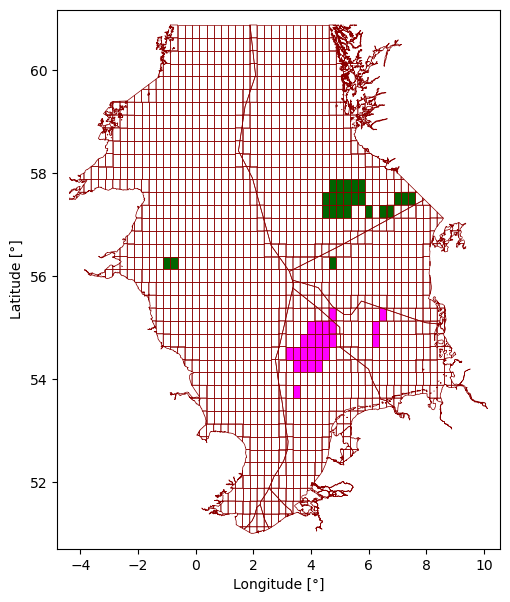

In [364]:
fig,ax = plt.subplots(figsize=(6,7))
ind_fow.iloc[0:24].plot(ax=ax,color='darkgreen')
ind_fb.iloc[0:24].plot(ax=ax, color='magenta')
new_grid.boundary.plot(ax=ax,color='darkred', linewidth= 0.5)

ax.set_xlabel("Longitude ["+degree+"]")
ax.set_ylabel("Latitude ["+degree+"]")
ax.margins(x=0.03,y=0.03)

plt.savefig("../figures/top_15_yield_fb.pdf", format="pdf", bbox_inches="tight")

In [365]:
fow_agg=yield_map_fow.groupby("MARREGION").sum()
fb_agg= yield_map_fb.groupby("MARREGION").sum()

In [366]:
fow_agg.index, fb_agg.index=('BE','DK','NL','FR','GER','NOR','UK'),('BE','DK','NL','FR','GER','NOR','UK')
fb_agg['yield_vals_fb']=fb_agg['yield_vals_fb'].div(1e3)
fow_agg['yield_vals_fow']=fow_agg['yield_vals_fow'].div(1e3)

df2 = pd.DataFrame(index=fb_agg.index).assign(yield_vals_fb=fb_agg['yield_vals_fb'], yield_vals_fow=fow_agg['yield_vals_fow'])


In [367]:
df2.sum(axis=1).sort_values(ascending=True)

FR       13.812811
BE       15.727275
GER     277.829469
DK      332.818751
NL      562.952743
NOR    1670.758683
UK     2811.402784
dtype: float64

In [368]:
#sort the stacked bar chart by hand from largest combined value to lowest
df2=df2.reindex(['UK','NOR','NL','DK','GER','BE','FR'])

[Text(0, 0, '308.41'),
 Text(0, 0, '4.07'),
 Text(0, 0, '562.47'),
 Text(0, 0, '142.52'),
 Text(0, 0, '270.87'),
 Text(0, 0, '15.67'),
 Text(0, 0, '13.77')]

Text(0, 0.5, 'Yield in [TWh]')

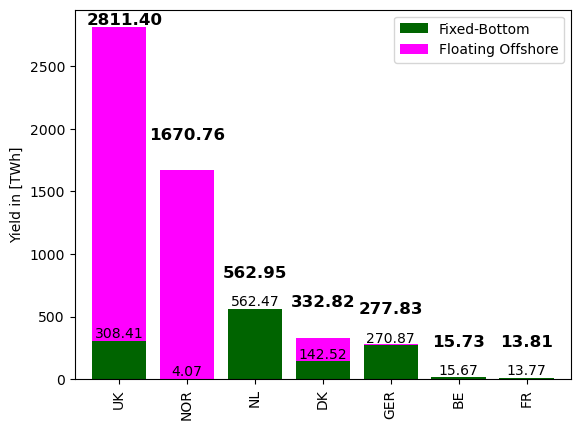

In [369]:
ax =df2.plot.bar(stacked=True,color= ['darkgreen','magenta'],width=0.8)


barlabels= ax.bar_label(ax.containers[1],padding =20,fmt='%.2f')
barlabels[0].set_position((4,0))

for x in barlabels:
    x.set_fontsize(12)
    x.set_fontweight("bold")

ax.bar_label(ax.containers[0],fmt='%.2f')

plt.ylabel('Yield in [TWh]')

plt.legend(loc='upper right', labels=('Fixed-Bottom', 'Floating Offshore'))

plt.savefig("../figures/yield_by_eez.pdf", format="pdf", bbox_inches="tight")



## How much area is still admissible?


In [370]:
#this repeats the creation of the capacity matrix
admissible_area_fb = A_fb.stack(spatial=["y", "x"]) * area2

admissible_area_fow = A_fow.stack(spatial=["y", "x"]) * area2

In [371]:
excluder_total = ExclusionContainer(crs=3035)
mask_total, transform_toal = shape_availability(shape, excluder_total)
total = cutout.availabilitymatrix(shape, excluder_total)
total_area = total.stack(spatial=["y", "x"]) * area2

Compute availability matrix: 100%|█████████████████████████████████████████| 1584/1584 [00:30<00:00, 52.54 gridcells/s]


Get an xarray matrix with all 1585 cells, so that we can get the actual area per EEZ
<br> One could have used the values from iho_eez, but so we stay consistent.
<br> Besides, areas are notoriously difficult to determine across CRS

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

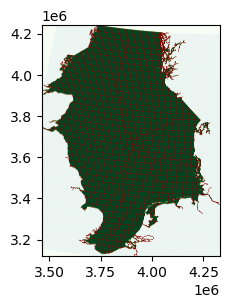

In [372]:
fig, ax = plt.subplots(figsize=(3,3)) 
cells.to_crs(3035).plot(ax=ax,alpha=0.05)
shape.boundary.plot(ax=ax, color='darkred',linewidth=0.15) #plots the boundaries of the cells
show(mask_total, transform=transform_toal, cmap='Greens', ax=ax)

In [373]:
bp=[0,677,687,704,909,1054,1216,1588]   
names= ['UK','FR','BE','NL','GER','DK','NOR'] # in this order the EEZs were written into the availability matrix

Percentage of Admissible Area by EEZ for Fixed-Bottom

In [374]:
for i,j in enumerate(bp):
    if i < len(bp)-1:
        t=float(admissible_area_fb.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").sum())
        z=float(total_area.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").sum())
        #second sum function necessary, so that we get one vale, that can be dispalyed as flaot
        str(names[i]) +' admissible percentage:'
        "{0:.2%}".format(round(t/z,4))

'UK admissible percentage:'

'11.53%'

'FR admissible percentage:'

'26.49%'

'BE admissible percentage:'

'13.89%'

'NL admissible percentage:'

'38.72%'

'GER admissible percentage:'

'23.33%'

'DK admissible percentage:'

'20.01%'

'NOR admissible percentage:'

'0.75%'

In [375]:
for i,j in enumerate(bp):
    if i < len(bp)-1:
        t=float(admissible_area_fow.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").sum())
        z=float(total_area.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").sum())
        #second sum function necessary, so that we get one vale, that can be dispalyed as flaot
        str(names[i]) +' admissible percentage:'
        "{0:.2%}".format(round(t/z,4))
        

'UK admissible percentage:'

'55.06%'

'FR admissible percentage:'

'0.58%'

'BE admissible percentage:'

'0.11%'

'NL admissible percentage:'

'0.04%'

'GER admissible percentage:'

'0.91%'

'DK admissible percentage:'

'19.83%'

'NOR admissible percentage:'

'75.30%'

Entire admissible area in relation to entire North Sea

In [376]:
o=float(admissible_area_fb.unstack().sum("dim_0").sum())
p=float(admissible_area_fow.unstack().sum("dim_0").sum())
q=float(total_area.unstack().sum("dim_0").sum())

'Admissible area for fixed-bottom in the North Sea'
"{0:.2%}".format(o/q)
'Admissible area for FOW in the North Sea'
"{0:.2%}".format(p/q)

'Admissible area for fixed-bottom in the North Sea'

'14.25%'

'Admissible area for FOW in the North Sea'

'44.67%'

**All capacity_matrices plotted along with the potential area**

In [377]:

#for i,j in enumerate(bp):
#    if i < len(bp)-1:
#        admissible_area_fb.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").plot()
#        plt.show() #necessary, because xarrays somehow overlays plotted images
#        'admissible area in sq.km per EEZ'
#        admissible_area_fb.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").sum()
#        'total area per EEZ'
#        total_area.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").sum()
#       
#        total_area.sel(dim_0=slice(bp[i],bp[i+1])).unstack().sum("dim_0").plot()
#        plt.show()

Define a cmap without over and under extremes.
<br> The markers will overlap, therefore a colour scale is necessary with colours that are perceptually far away from each other.

In [378]:
mycmap3 = matplotlib.colors.ListedColormap(
    ["#1b9e77", '#d95f02',"#7570b3",'#BBF90F','blue'])
#the colormaps above hat specific "over" and "under" colour values, that is not desirable for the next plots

In [379]:
yield_curve_fow['distance_to_landfall'].max()
yield_curve_fow['distance_to_landfall'].min()

299948.5783390321

4.950373876088992

Remember: yield_map_fow/fb was the sorted curve

**Plotting Yield against mean depth, and Distance as third dimension**
<br> remove mean depth values below 60 for fixed-bottom

Text(0.5, 0, 'Yield Values in [GWh]')

Text(0, 0.5, 'Mean Depth')

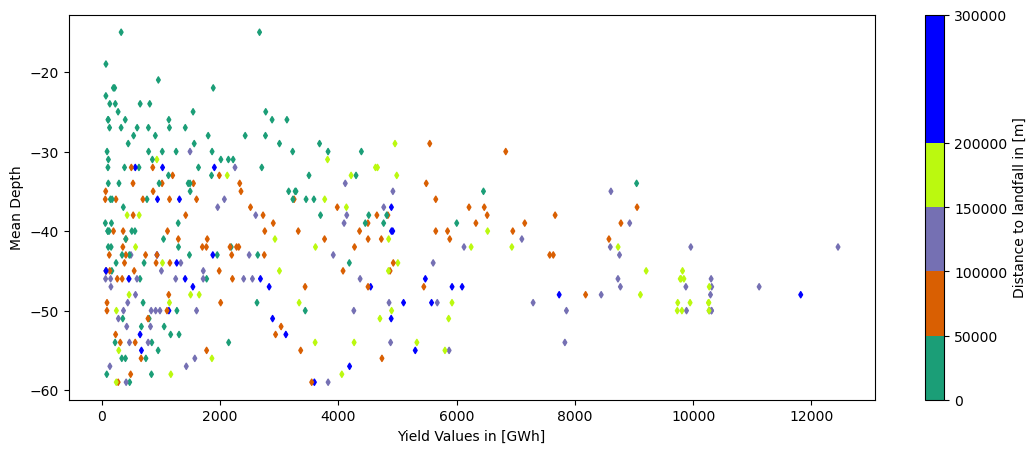

In [380]:
yield_curve_fb_ldf=yield_curve_fb[(yield_curve_fb['yield_vals_fb']>50) & (yield_curve_fb['mean_depth']>-60)]
a2 = np.array([0,50,100,150,200,300])* 1e3


norm=mpl.colors.BoundaryNorm(boundaries=a2, ncolors=len(a2)-1)

fig,ax= plt.subplots(figsize=(13,5))
img= plt.scatter(yield_curve_fb_ldf['yield_vals_fb'],yield_curve_fb_ldf['mean_depth'],c=yield_curve_fb_ldf['distance_to_landfall']
                 ,s=10,
                 norm=norm ,
                 cmap=mycmap3,
                 marker= "d"               )
fig.colorbar(img, ax=ax
            ,spacing='proportional'
             
            ).set_label('Distance to landfall in [m]', rotation=90)

ax.set_xlabel("Yield Values in [GWh]")
ax.set_ylabel("Mean Depth")

plt.savefig("../figures/yld_vs_depth_fb.pdf", format="pdf", bbox_inches="tight")



Remove great depths below -200 for easier interpretation for floating wind.
<br> Boundaries in the colour bar slightly altered for shorter distances

Text(0.5, 0, 'Yield Values')

Text(0, 0.5, 'Mean Depth')

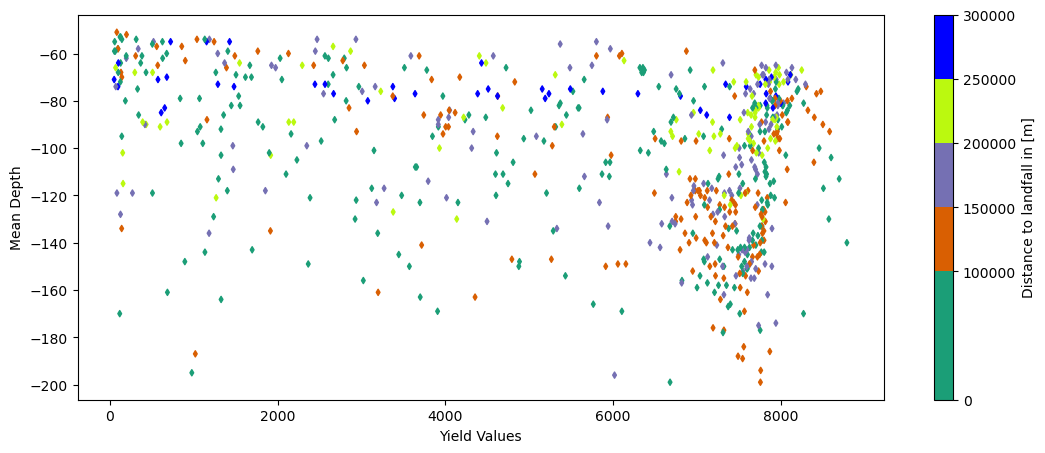

In [381]:
yield_curve_fow_ldf=yield_curve_fow[(yield_curve_fow['yield_vals_fow']>50) & (yield_curve_fow['mean_depth']>-200)]
a2 = np.array([0,100,150,200,250,300])* 1e3


norm=mpl.colors.BoundaryNorm(boundaries=a2, ncolors=len(a2)-1)

fig,ax= plt.subplots(figsize=(13,5))
img= plt.scatter(yield_curve_fow_ldf['yield_vals_fow'],yield_curve_fow_ldf['mean_depth'],c=yield_curve_fow_ldf['distance_to_landfall']
                 ,s=10,
                 norm=norm ,
                 cmap=mycmap3,
                 marker= "d"               )
fig.colorbar(img, ax=ax
            ,spacing='proportional'
              
            ).set_label('Distance to landfall in [m]', rotation=90)

ax.set_xlabel("Yield Values")
ax.set_ylabel("Mean Depth")
plt.savefig("../figures/yld_vs_depth_fow.pdf", format="pdf", bbox_inches="tight")




**Plotting Yield against Distance to Landfall and Depth as third dimension**

For FB, there are no depths below 50

Text(0.5, 0, 'Yield Values in [GWh]')

Text(0, 0.5, 'Distance to Landfall in [m]')

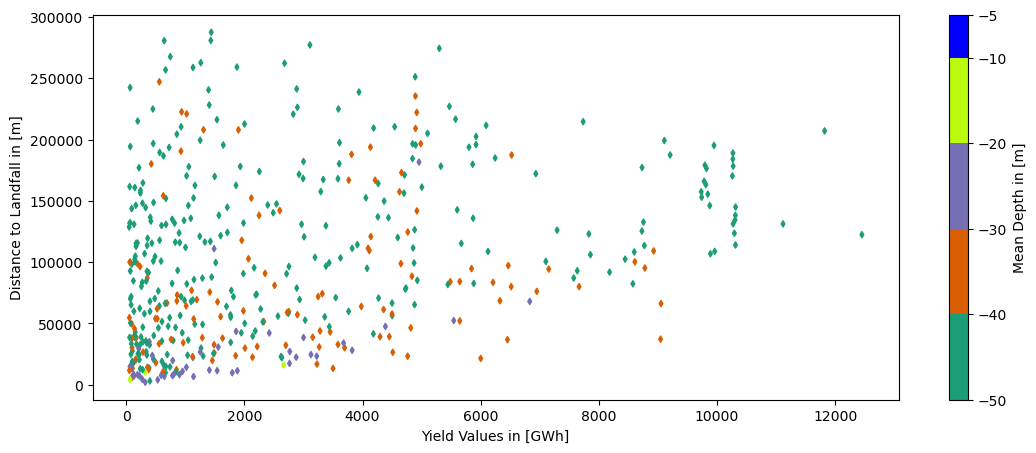

In [382]:
yield_curve_fb_dpt=yield_curve_fb[yield_curve_fb['yield_vals_fb']>50]
a2 = np.array([-50,-40,-30,-20,-10,-5])


norm=mpl.colors.BoundaryNorm(boundaries=a2, ncolors=len(a2)-1)

fig,ax= plt.subplots(figsize=(13,5))
img= plt.scatter(yield_curve_fb_dpt['yield_vals_fb'],yield_curve_fb_dpt['distance_to_landfall'],c=yield_curve_fb_dpt['mean_depth']
                 ,s=10,
                 norm=norm ,
                 cmap=mycmap3,
                 marker= "d")
fig.colorbar(img, ax=ax
            ,spacing='proportional'
             ).set_label('Mean Depth in [m]', rotation=90)

ax.set_xlabel("Yield Values in [GWh]")
ax.set_ylabel("Distance to Landfall in [m]")

plt.savefig("../figures/yld_vs_landfall_fb.pdf", format="pdf", bbox_inches="tight")


FOW has only depths below 50 m, see colour bar

Text(0.5, 0, 'Yield Values in [GWh]')

Text(0, 0.5, 'Distance to Landfall in [m]')

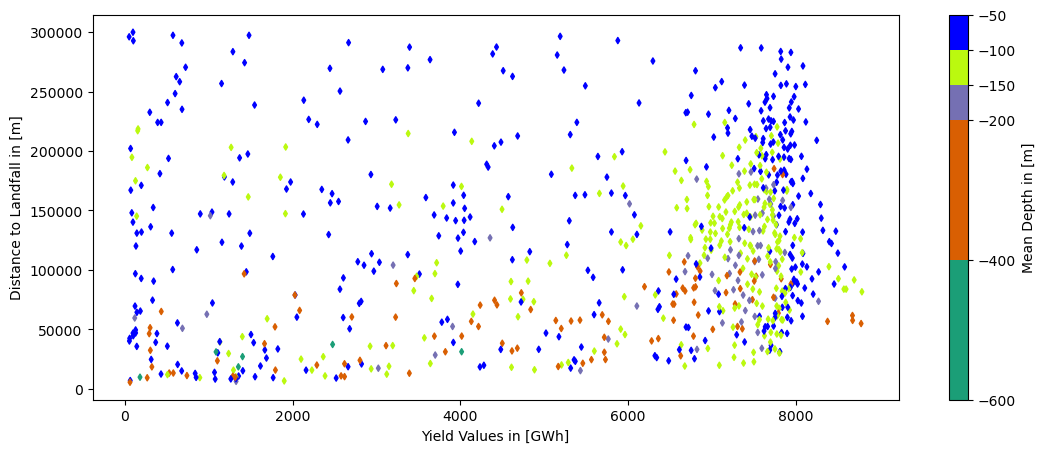

In [383]:
yield_curve_fow_dpt=yield_curve_fow[yield_curve_fow['yield_vals_fow']>50]
a2 = np.array([-600,-400,-200,-150,-100,-50])


norm=mpl.colors.BoundaryNorm(boundaries=a2, ncolors=len(a2)-1)

fig,ax= plt.subplots(figsize=(13,5))
img= plt.scatter(yield_curve_fow_dpt['yield_vals_fow'],yield_curve_fow_dpt['distance_to_landfall'],c=yield_curve_fow_dpt['mean_depth']
                 ,s=10,
                 norm=norm ,
                 cmap=mycmap3,
                 marker= "d"               )
fig.colorbar(img, ax=ax
            ,spacing='proportional'
              
            ).set_label('Mean Depth in [m]', rotation=90)

ax.set_xlabel("Yield Values in [GWh]")
ax.set_ylabel("Distance to Landfall in [m]")
plt.savefig("../figures/yld_vs_landfall_fow.pdf", format="pdf", bbox_inches="tight")


**Plotting distance againts mean depth, yield as a third dimension**

The mean depth can be lower than -50 due to slopes within the cell, I'll exlcude these.

Text(0.5, 0, 'Distance to Landfall in [m]')

Text(0, 0.5, 'Mean Depth in [GWh]')

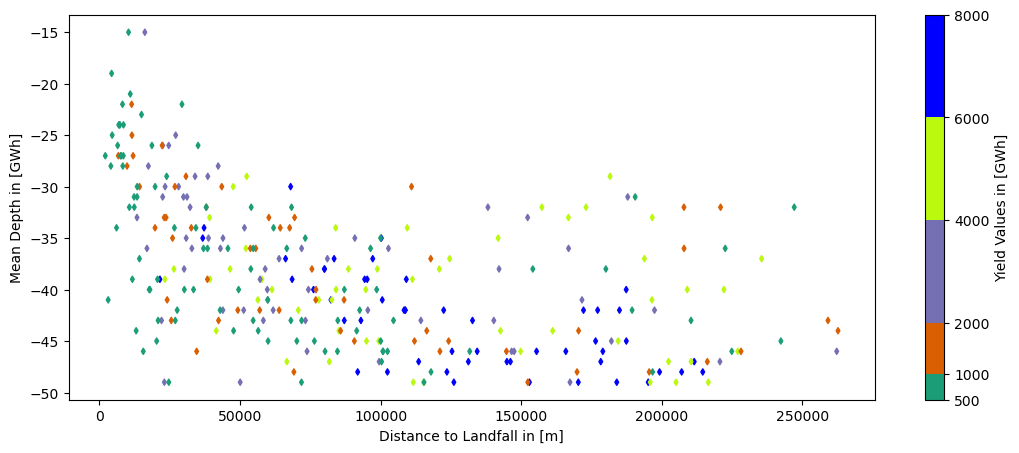

In [384]:
yield_curve_fb_yld=yield_curve_fb[(yield_curve_fb['yield_vals_fb']>50)&(yield_curve_fb['mean_depth']>-50)]
a2 = np.array([0.5, 1, 2,4,6,8])*1e3


norm=mpl.colors.BoundaryNorm(boundaries=a2, ncolors=len(a2)-1)

fig,ax= plt.subplots(figsize=(13,5))
img= plt.scatter(yield_curve_fb_yld['distance_to_landfall'],yield_curve_fb_yld['mean_depth'],c=yield_curve_fb_yld['yield_vals_fb']
                 ,s=10,
                 norm=norm ,
                 cmap=mycmap3,
                 marker= "d" )
fig.colorbar(img, ax=ax
            ,spacing='proportional').set_label('Yield Values in [GWh]', rotation=90)

ax.set_xlabel("Distance to Landfall in [m]")
ax.set_ylabel("Mean Depth in [GWh]")

plt.savefig("../figures/landfall_vs_depth_fb.pdf", format="pdf", bbox_inches="tight")


*For FB definitely one can see a inverse regression curve --> top yields in blue follow rule: the further out, the deeper*

I will exclude depths below -400 for easier interpretation for FOW

Text(0.5, 0, 'Distance to Landfall in [m]')

Text(0, 0.5, 'Mean Depth in [GWh]')

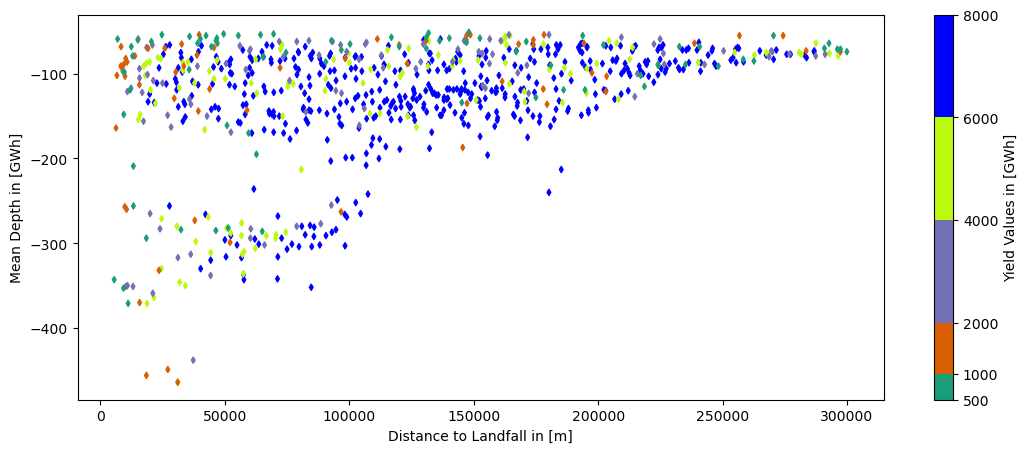

In [385]:
yield_curve_fow_yld=yield_curve_fow[(yield_curve_fow['yield_vals_fow']>50)&(yield_curve_fow['mean_depth']>-500)]
a2 = np.array([0.5, 1, 2,4,6,8])*1e3


norm=mpl.colors.BoundaryNorm(boundaries=a2, ncolors=len(a2)-1)

fig,ax= plt.subplots(figsize=(13,5))
img= plt.scatter(yield_curve_fow_yld['distance_to_landfall'],yield_curve_fow_yld['mean_depth'],c=yield_curve_fow_yld['yield_vals_fow']
                 ,s=10,
                 norm=norm ,
                 cmap=mycmap3,
                 marker= "d")
fig.colorbar(img, ax=ax
            ,spacing='proportional').set_label('Yield Values in [GWh]', rotation=90)

ax.set_xlabel("Distance to Landfall in [m]")
ax.set_ylabel("Mean Depth in [GWh]")

plt.savefig("../figures/landfall_vs_depth_fow.pdf", format="pdf", bbox_inches="tight")


The almost horizontal line in the sorted curve is recognizable --> in blue are the top values.

In [386]:
end = time.time()
print(end-start)

338.1508731842041
